# Experiments Notebook 1


In [ ]:
!pip install pydot

In [ ]:
!pip install keras-hypetune

In [41]:
import os
import os.path
import pickle
import bz2
from glob import glob
import random
import shutil
from datetime import datetime
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
from kerashypetune import KerasGridSearch


import preprocessing as pp
import dsci592.model as dsci

In [2]:
pd.set_option("display.max_columns", None)

### Load the golden data

In [ ]:
# Windows version
golden_dataset_file_name = os.path.join('..', '..', 'data', 'golden', 'feeFiFoFum.pbz2')

# data = bz2.BZ2File(golden_dataset_file_name,'rb')
with bz2.BZ2File(golden_dataset_file_name,'rb') as data:
    df = pd.read_pickle(data)
df

In [3]:
# Linux version (problems with bz2 file)

golden_dataset_file_name = os.path.join('/', 'data', 'projects', 'drexel', 'dsci592', 'feeFiFoFum.pkl')

df = pd.read_pickle(golden_dataset_file_name)
df

,dates,JHU_ConfirmedCases.data,NYT_ConfirmedCases.data,JHU_ConfirmedDeaths.data,NYT_ConfirmedDeaths.data,NYT_ConfirmedDeaths.missing,TotalPopulation.data,MaleAndFemale_AtLeast65_Population.data,Male_Total_Population.data,Female_Total_Population.data,MaleAndFemale_Under18_Population.data,BLS_EmployedPopulation.data,BLS_EmployedPopulation.missing,BLS_UnemployedPopulation.data,BLS_UnemployedPopulation.missing,BLS_UnemploymentRate.data,BLS_UnemploymentRate.missing,BLS_LaborForcePopulation.data,BLS_LaborForcePopulation.missing,AverageDailyTemperature.data,AverageDailyTemperature.missing,AverageDewPoint.data,AverageDewPoint.missing,AverageRelativeHumidity.data,AverageRelativeHumidity.missing,AverageSurfaceAirPressure.data,AverageSurfaceAirPressure.missing,AveragePrecipitationTotal.data,AveragePrecipitationTotal.missing,AveragePrecipitation.data,AveragePrecipitation.missing,AverageWindDirection.data,AverageWindDirection.missing,AverageWindSpeed.data,AverageWindSpeed.missing,hospitalIcuBeds,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,fips,county,jhu_daily_death,jhu_daily_cases,jhu_daily_new_cases,jhu_daily_death_rolling_7,jhu_daily_cases_rolling_7,jhu_daily_new_cases_rolling_7,jhu_daily_death_rolling_30,jhu_daily_cases_rolling_30,jhu_daily_new_cases_rolling_30,LND110210,jhu_death_rate,jhu_case_rate,jhu_new_case_rate,density,icu_beds_per_person,staffed_beds_per_person,licensed_beds_per_person,cold_days,hot_days,moderate_days,gte_65_percent,lt_18_percent,employed_percent,unemployed_percent,totalMoved,movedWithinState,movedWithoutState,movedFromAbroad,publicTrans,totalTrans,householdsTotal,houseWith65,house2+with65,houseFamily65,houseNonfam65,houseNo65,house2+No65,houseFamilyNo65,houseNonfamNo65,householdStructuresTotal,householdIncomeMedian,gini,hoursWorkedMean,unitsInStructure,healthInsTotal,healthInsNativeWith,healthInsForeignNatWith,healthInsForeignNoncitWith,healthInsForeignNatNo,healthInsForeignNoncitNo,healthInsNativeNo,countyStateName,stateFip,countyFip,pm25
0,2020-03-19,1.0,1.0,0.0,0.0,0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,386.5,0.0,3.825596,0.0,10103.0,0.0,68.659722,0.0,63.152778,0.0,84.152778,0.0,29.590139,0.0,0.000833,0.0,0.000000,0.0,192.326389,0.0,6.732639,0.0,6.0,25.0,25.0,24527.0,45001,Abbeville_SouthCarolina_UnitedStates,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,490.48,0.0,0.000000,0.000000,50.006116,0.000245,0.001019,0.001019,0,0,1,0.217842,0.200758,0.961744,0.038256,24317.0,1118.0,329.0,12.0,44,9791,9660,3645,2081,2042,39,6015,4531,4206,325,9660,38741,0.4790,38.1,12191,24397,21415,179,87,39,122,2555,"Abbeville County, South Carolina",45,001,9.618551
1,2020-03-20,1.0,1.0,0.0,0.0,0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,386.5,0.0,3.825596,0.0,10103.0,0.0,72.541667,0.0,60.583333,0.0,68.708333,0.0,29.537708,0.0,0.000000,0.0,0.000000,0.0,208.125000,0.0,10.833333,0.0,6.0,25.0,25.0,24527.0,45001,Abbeville_SouthCarolina_UnitedStates,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,490.48,0.0,0.000000,0.000000,50.006116,0.000245,0.001019,0.001019,0,0,1,0.217842,0.200758,0.961744,0.038256,24317.0,1118.0,329.0,12.0,44,9791,9660,3645,2081,2042,39,6015,4531,4206,325,9660,38741,0.4790,38.1,12191,24397,21415,179,87,39,122,2555,"Abbeville County, South Carolina",45,001,9.618551
2,2020-03-21,1.0,1.0,0.0,0.0,0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,386.5,0.0,3.825596,0.0,10103.0,0.0,69.208333,0.0,56.708333,0.0,66.583333,0.0,29.520417,0.0,0.000000,0.0,0.000000,0.0,252.916667,0.0,8.125000,0.0,6.0,25.0,25.0,24527.0,45001,Abbeville_SouthCarolina_UnitedStates,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,490.48,0.0,0.000000,0.000000,50.006116,0.000245,0.001019,0.001019,0,0,1,0.217842,0.200758,0.961744,0.038256,24317.0,1118.0,329.0,12.0,44,9791,9660,3645,2081,2042,39,6015,4531,4206,325,9660,38741,0.4790,38.1,12191,24397,21415,179,87,39,122,2555,"Abbeville County, South Carolina",45,001,9.618551
3,2020-03-22,1.0,1.0,0.0,0.0,0,24527.0,5343.0,11868.

### Clean up the data

#### Drop non-numeric and unnecessary columns

In [4]:
cols = ['NYT_ConfirmedCases.data','NYT_ConfirmedDeaths.data','NYT_ConfirmedDeaths.missing','county','LND110210','countyStateName','stateFip','countyFip']

df.drop(cols, axis=1, inplace=True)

#### Temporarily, replace FIPS codes with latitude and longitude of the centroid of each county

In [5]:
counties = pd.read_csv('2021_Gaz_counties_national.txt', delimiter='\t')
counties.rename(columns={'INTPTLONG                                                                                                               ': 'longitude',
                        'INTPTLAT': 'latitude'}, inplace=True)

In [6]:
counties = counties[['GEOID', 'latitude', 'longitude' ]]
df.fips = df.fips.astype('int64')

df = df.merge(counties, how='left', left_on='fips', right_on='GEOID')
df.drop(['GEOID'], axis=1, inplace=True)

#### Replace dates with monotonically increasing integers starting with the minimum date

In [7]:
df.dates = pd.to_datetime(df.dates, format='%Y-%m-%d')
min_date = min(df.dates)
max_date = max(df.dates)
min_date, max_date, df.dates.dtype

(Timestamp('2020-03-11 00:00:00'),
 Timestamp('2022-01-16 00:00:00'),
 dtype('<M8[ns]'))

In [8]:
df['day'] =(df.dates - min_date).dt.days
df.drop(['dates'], axis=1, inplace=True)

#### Replace the integer representation of date with sin and cosine encoding

In [9]:
cyclical_interval = 365
continuous_interval = 3650
df['cyclical_sin'] = np.sin((df.day * 2 * np.pi)/cyclical_interval)
df['cyclical_cos'] = np.cos((df.day * 2 * np.pi)/cyclical_interval)
df['continuous_sin'] = np.sin((df.day * 2 * np.pi)/continuous_interval)
df['continuous_cos'] = np.cos((df.day * 2 * np.pi)/continuous_interval)
df.drop('day', axis=1, inplace=True)

#### Get the feature column for latitude and longitude

In [10]:
# crossed_latlong = pp.get_latlong_fc(df)

lat_buckets = list(np.linspace(df.latitude.min(), df.latitude.max(),100))
long_buckets = list(np.linspace(df.longitude.min(), df.longitude.max(),100))

#make feature columns
lat_fc = tf.feature_column.bucketized_column(tf.feature_column.numeric_column('latitude'),lat_buckets)
long_fc= tf.feature_column.bucketized_column(tf.feature_column.numeric_column('longitude'),long_buckets)
    
# crossed columns tell the model how the features relate
crossed_latlong = tf.feature_column.crossed_column(keys=[lat_fc, long_fc], hash_bucket_size=1000) # No precise rule, maybe 1000 buckets will be good?
    
embedded_latlong = tf.feature_column.embedding_column(crossed_latlong,9)

feature_layer = tf.keras.layers.DenseFeatures(embedded_latlong)

df[['geo0', 'geo1', 'geo2','geo3', 'geo4','geo5','geo6','geo7','geo8']] = feature_layer({'latitude': df.latitude, 'longitude': df.longitude})

# df.drop(['longitude', 'latitude'], axis=1, inplace=True)

2022-02-15 19:30:43.511875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 19:30:43.512123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 19:30:43.535784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 19:30:43.536014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 19:30:43.536211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [11]:
df

,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,TotalPopulation.data,MaleAndFemale_AtLeast65_Population.data,Male_Total_Population.data,Female_Total_Population.data,MaleAndFemale_Under18_Population.data,BLS_EmployedPopulation.data,BLS_EmployedPopulation.missing,BLS_UnemployedPopulation.data,BLS_UnemployedPopulation.missing,BLS_UnemploymentRate.data,BLS_UnemploymentRate.missing,BLS_LaborForcePopulation.data,BLS_LaborForcePopulation.missing,AverageDailyTemperature.data,AverageDailyTemperature.missing,AverageDewPoint.data,AverageDewPoint.missing,AverageRelativeHumidity.data,AverageRelativeHumidity.missing,AverageSurfaceAirPressure.data,AverageSurfaceAirPressure.missing,AveragePrecipitationTotal.data,AveragePrecipitationTotal.missing,AveragePrecipitation.data,AveragePrecipitation.missing,AverageWindDirection.data,AverageWindDirection.missing,AverageWindSpeed.data,AverageWindSpeed.missing,hospitalIcuBeds,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,fips,jhu_daily_death,jhu_daily_cases,jhu_daily_new_cases,jhu_daily_death_rolling_7,jhu_daily_cases_rolling_7,jhu_daily_new_cases_rolling_7,jhu_daily_death_rolling_30,jhu_daily_cases_rolling_30,jhu_daily_new_cases_rolling_30,jhu_death_rate,jhu_case_rate,jhu_new_case_rate,density,icu_beds_per_person,staffed_beds_per_person,licensed_beds_per_person,cold_days,hot_days,moderate_days,gte_65_percent,lt_18_percent,employed_percent,unemployed_percent,totalMoved,movedWithinState,movedWithoutState,movedFromAbroad,publicTrans,totalTrans,householdsTotal,houseWith65,house2+with65,houseFamily65,houseNonfam65,houseNo65,house2+No65,houseFamilyNo65,houseNonfamNo65,householdStructuresTotal,householdIncomeMedian,gini,hoursWorkedMean,unitsInStructure,healthInsTotal,healthInsNativeWith,healthInsForeignNatWith,healthInsForeignNoncitWith,healthInsForeignNatNo,healthInsForeignNoncitNo,healthInsNativeNo,pm25,latitude,longitude,cyclical_sin,cyclical_cos,continuous_sin,continuous_cos,geo0,geo1,geo2,geo3,geo4,geo5,geo6,geo7,geo8
0,1.0,0.0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,386.5,0.0,3.825596,0.0,10103.0,0.0,68.659722,0.0,63.152778,0.0,84.152778,0.0,29.590139,0.0,0.000833,0.0,0.000000,0.0,192.326389,0.0,6.732639,0.0,6.0,25.0,25.0,24527.0,45001,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,50.006116,0.000245,0.001019,0.001019,0,0,1,0.217842,0.200758,0.961744,0.038256,24317.0,1118.0,329.0,12.0,44,9791,9660,3645,2081,2042,39,6015,4531,4206,325,9660,38741,0.4790,38.1,12191,24397,21415,179,87,39,122,2555,9.618551,34.229041,-82.454058,0.137279,0.990532,0.013771,0.999905,0.228193,0.295447,-0.247483,0.157952,0.272770,-0.168312,-0.329012,0.395681,0.359578
1,1.0,0.0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,386.5,0.0,3.825596,0.0,10103.0,0.0,72.541667,0.0,60.583333,0.0,68.708333,0.0,29.537708,0.0,0.000000,0.0,0.000000,0.0,208.125000,0.0,10.833333,0.0,6.0,25.0,25.0,24527.0,45001,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,50.006116,0.000245,0.001019,0.001019,0,0,1,0.217842,0.200758,0.961744,0.038256,24317.0,1118.0,329.0,12.0,44,9791,9660,3645,2081,2042,39,6015,4531,4206,325,9660,38741,0.4790,38.1,12191,24397,21415,179,87,39,122,2555,9.618551,34.229041,-82.454058,0.154309,0.988023,0.015492,0.999880,0.228193,0.295447,-0.247483,0.157952,0.272770,-0.168312,-0.329012,0.395681,0.359578
2,1.0,0.0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,386.5,0.0,3.825596,0.0,10103.0,0.0,69.208333,0.0,56.708333,0.0,66.583333,0.0,29.520417,0.0,0.000000,0.0,0.000000,0.0,252.916667,0.0,8.125000,0.0,6.0,25.0,25.0,24527.0,45001,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,50.006116,0.000245,0.001019,0.001019,0,0,1,0.217842,0.200758,0.961744,0.038256,24317.0,1118.0,329.0,12.0,44,9791,9660,3645,2081,2042,39,6015,4531,4206,325,9660,38741,0.4790,38.1,12191,24397,21415,179,87,39,122,2555,9.618551,34.229041,-82.454058,0.171293,0.985220,0.017213,0.999852,0.228193,0.295447,-0.247483,0.157952,0.272770,-0.

#### Normalize the data

In [12]:
cols_to_normalize = [
       'TotalPopulation.data', 'MaleAndFemale_AtLeast65_Population.data',
       'Male_Total_Population.data', 'Female_Total_Population.data',
       'MaleAndFemale_Under18_Population.data', 'BLS_EmployedPopulation.data',
       'BLS_EmployedPopulation.missing', 'BLS_UnemployedPopulation.data',
       'BLS_UnemployedPopulation.missing', 'BLS_UnemploymentRate.data',
       'BLS_UnemploymentRate.missing', 'BLS_LaborForcePopulation.data',
       'BLS_LaborForcePopulation.missing', 'AverageDailyTemperature.data',
       'AverageDailyTemperature.missing', 'AverageDewPoint.data',
       'AverageDewPoint.missing', 'AverageRelativeHumidity.data',
       'AverageRelativeHumidity.missing', 'AverageSurfaceAirPressure.data',
       'AverageSurfaceAirPressure.missing', 'AveragePrecipitationTotal.data',
       'AveragePrecipitationTotal.missing', 'AveragePrecipitation.data',
       'AveragePrecipitation.missing', 'AverageWindDirection.data',
       'AverageWindDirection.missing', 'AverageWindSpeed.data',
       'AverageWindSpeed.missing', 'hospitalIcuBeds', 'hospitalStaffedBeds',
       'hospitalLicensedBeds', 'latestTotalPopulation', 'jhu_daily_death',
       'jhu_daily_cases', 'jhu_daily_new_cases', 
    'jhu_daily_death_rolling_7',
       'jhu_daily_cases_rolling_7', 'jhu_daily_new_cases_rolling_7',
       'jhu_daily_death_rolling_30', 'jhu_daily_cases_rolling_30',
       'jhu_daily_new_cases_rolling_30', 'jhu_death_rate', 'jhu_case_rate',
       'jhu_new_case_rate', 'density', 'icu_beds_per_person',
       'staffed_beds_per_person', 'licensed_beds_per_person', 'cold_days',
       'hot_days', 'moderate_days', 'gte_65_percent', 'lt_18_percent',
       'employed_percent', 'unemployed_percent', 'totalMoved',
       'movedWithinState', 'movedWithoutState', 'movedFromAbroad',
       'publicTrans', 'totalTrans', 'householdsTotal', 'houseWith65',
       'house2+with65', 'houseFamily65', 'houseNonfam65', 'houseNo65',
       'house2+No65', 'houseFamilyNo65', 'houseNonfamNo65',
       'householdStructuresTotal', 'householdIncomeMedian', 'gini',
       'hoursWorkedMean', 'unitsInStructure', 'healthInsTotal',
       'healthInsNativeWith', 'healthInsForeignNatWith',
       'healthInsForeignNoncitWith', 'healthInsForeignNatNo',
       'healthInsForeignNoncitNo', 'healthInsNativeNo', 'pm25', 'latitude',
       'longitude']
cols_raw = ['fips','JHU_ConfirmedCases.data', 'JHU_ConfirmedDeaths.data', 'cyclical_sin', 'cyclical_cos', 'continuous_sin',
       'continuous_cos', 'geo0', 'geo1', 'geo2','geo3', 'geo4','geo5','geo6','geo7','geo8']
df_normalized = df[cols_to_normalize]
df_normalized = (df_normalized - df_normalized.mean())/df_normalized.std()
df_raw = df[cols_raw]
df = pd.concat([df_raw, df_normalized], axis=1)


#### Prepare the data for training

In [13]:
days_of_history = 30
days_to_predict = 1

In [14]:
fips = df.fips.unique()

# def x_generator(data, days_of_history=30, days_to_predict=1):
#     for j, fip in enumerate(fips):
#         if not j % 100: print(j, end=' ')
#         county = data[data.fips == fip]
#         for i in range(days_of_history, len(county) - days_to_predict):
#             data_matrix = data.iloc[i - days_of_history: i, 1:].to_numpy()
#             yield data_matrix
            
# def y_generator(data, days_of_history=30, days_to_predict=1):
#     for fip in fips:
#         county = data[data.fips == fip]
#         for i in range(days_of_history, len(county) - days_to_predict):
#             data_matrix = data.iloc[i: i + days_to_predict, 1:3].to_numpy()
#             yield data_matrix
    
def xy_generator(data, days=31):
    for j, fip in enumerate(fips):
        if not j % 100: print(j, end=' ')
        county = data[data.fips == fip]
        for i in range(days, len(county) + 1):
            data_matrix = data.iloc[i - days: i, 1:].to_numpy()
            yield data_matrix
            
        
            
    

##### Save the raw X and Y to files of 50,000 sequences

In [ ]:
Xi = []
j = 0

N_SAMPLES = 200

for i, x in enumerate(xy_generator(df)):
    Xi.append(x)
    if i and not i % (N_SAMPLES - 1):
        X = np.asarray(Xi)
        np.save(os.path.join('.','data', f'x_{j}.npy'), X)
        j += 1
        Xi = []
if Xi:
    X = np.asarray(Xi)
    np.save(os.path.join('.','data', f'x_{j}.npy'), X)
 



In [ ]:
x = np.load('./data/x_0.npy')
x.shape

##### Split into train, test, eval directories

In [2]:
RANDOM_SEED = 42
def set_seed():
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.random.set_seed(RANDOM_SEED)
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
set_seed()

In [ ]:
x_files = glob('./data/x_*.npy')
random.shuffle(x_files)
n_files = len(x_files)
print(n_files)
n_train = int(n_files * 0.70)
print(n_train)
n_eval = int(n_files * 0.15)
print(n_eval)
n_test = n_files - n_train - n_eval
print(n_test)
train_files = x_files[:n_train]
# print(len(train_files))
eval_files = x_files[n_train:n_train+n_test]
# print(len(eval_files))
test_files = x_files[n_train+n_test:]
assert n_files == len(train_files) + len(eval_files) + len(test_files)
for (subdir, lst) in [['train', train_files], ['eval', eval_files], ['test', test_files]]:
    for file in lst:
        shutil.move(file, os.path.join('.', 'data', subdir))
        

##### Create the Tensorflow Dataset

In [3]:
train_files = glob('./data/train/x_*.npy')
eval_files = glob('./data/eval/x_*.npy')
test_files = glob('./data/test/x_*.npy')

n_readers = 5
n_parse_threads = 5
len_array = 995

def create_generator(files, cycle_length=5):
    set_seed()
    random.shuffle(files)
    for i in range(0, len(files), cycle_length):
        subset = files[i:i+cycle_length]
        np_arrays = [np.load(s) for s in subset]
        np_array = np.concatenate(np_arrays, axis=0)
        np.random.shuffle(np_array)
        yield np_array
            

def split_xy(np_array):
    X = np_array[:,:-1,:]
    y = np_array[:,-1:,:1]
    return X,y
        
    
train_ds = tf.data.Dataset.from_generator(lambda: create_generator(train_files, cycle_length=n_readers), output_types=tf.float32 )
train_ds = train_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)

val_ds = tf.data.Dataset.from_generator(lambda: create_generator(eval_files, cycle_length=n_readers), output_types=tf.float32 )
val_ds = val_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)

test_ds = tf.data.Dataset.from_generator(lambda: create_generator(test_files, cycle_length=n_readers), output_types=tf.float32 )
test_ds = test_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)


2022-02-17 16:36:12.807873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 16:36:12.808120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 16:36:12.834207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 16:36:12.834439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 16:36:12.834634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [ ]:
# for x in train_ds.take(3):
#     print(x)

## Building the model

In [ ]:
param_grid = {
    'recurrent_layer_type': [keras.layers.LSTM, keras.layers.GRU],
    'n_recurrent': [1, 2, 3],
    'unit': [32, 64, 128],
    'dropout': [0.0, 0.10, 0.20],
    'lr': [1e-2, 1e-3],   
    'epochs': 256,
}

In [ ]:
def build_model(param, shape=(30,101)):
    input = keras.layers.Input(shape=shape)
    last = input
    for i in range(param['n_recurrent']):
        last = param['recurrent_layer_type'](param['unit'])(last)
        if param['dropout']:
            last = keras.layers.Dropout(param['dropout'])(last)
    output = keras.layers.Dense(1)(last)
    model = keras.models.Model(inputs=input, outputs=output)
    model.compile(optimizer = Adam(learning_rate=param['lr']),  loss='mae',  metrics=['mse', 'mae'])
        
    return model


                      

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='mae', patience=10, restore_best_weights=True)

n_trial = 3

name = f'trial_{n_trial}'
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")

checkpoint_cb = keras.callbacks.ModelCheckpoint(f'./data/model/{name}_{timestamp}.h5', save_best_only=True)
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs/{}".format(name))


hypermodel = lambda param: build_model(param=param)

kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(train_ds, validation_data=val_ds, callbacks=[early_stopping_cb, checkpoint_cb, tensorboard], shuffle=False)


### Hyperparameter tuning 

Using technique from https://medium.com/ml-book/neural-networks-hyperparameter-tuning-in-tensorflow-2-0-a7b4e2b574a1

In [17]:
# HP_LAYER_TYPE=hp.HParam('layer_type', hp.Discrete(['keras.layers.LSTM', 'keras.layers.GRU']))
HP_LAYER_TYPE=hp.HParam('layer_type', hp.Discrete(['keras.layers.LSTM']))
HP_N_RECURRENT=hp.HParam('n_recurrent', hp.Discrete([1, 2, 3]))
# HP_N_UNIT=hp.HParam('n_unit', hp.Discrete([32, 64, 128]))
HP_N_UNIT=hp.HParam('n_unit', hp.Discrete([128]))
HP_DROPOUT=hp.HParam('dropout', hp.Discrete([0.20]))
HP_LR=hp.HParam('lr', hp.Discrete([1e-3]))
METRIC_MAE = 'mae'


with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_LAYER_TYPE, HP_N_RECURRENT, HP_N_UNIT, HP_DROPOUT, HP_LR],
    metrics=[hp.Metric(METRIC_MAE, display_name='Mean Avg Error')],
  )

In [18]:
EPOCHS=64

def train_test_model(hparams, shape=(30,92)):
    set_seed()
    input = keras.layers.Input(shape=shape)
    last = input
    for i in range(hparams[HP_N_RECURRENT]):
        if i < hparams[HP_N_RECURRENT] - 1:
            last = eval(hparams[HP_LAYER_TYPE])(hparams[HP_N_UNIT], return_sequences=True)(last)
        else:
            last = eval(hparams[HP_LAYER_TYPE])(hparams[HP_N_UNIT])(last)
        
        if hparams[HP_DROPOUT]:
            last = keras.layers.Dropout(hparams[HP_DROPOUT])(last)

        output = keras.layers.Dense(1)(last)
    
    model = keras.models.Model(inputs=input, outputs=output)
    model.compile(optimizer = Adam(learning_rate=hparams[HP_LR]),  loss='mae')

    model.fit(train_ds,
            validation_data=val_ds,
            epochs=EPOCHS)
 
    val_loss = model.evaluate(test_ds)
    return val_loss
        

def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        val_loss = train_test_model(hparams)
        tf.summary.scalar(METRIC_MAE, val_loss, step=1)

In [19]:
session_num = 0
for layer_type in HP_LAYER_TYPE.domain.values:
    for n_recurrent in HP_N_RECURRENT.domain.values:
        for n_unit in HP_N_UNIT.domain.values:
            for dropout in HP_DROPOUT.domain.values:
                for lr in HP_LR.domain.values:
                    hparams = {
                      HP_LAYER_TYPE: layer_type,
                      HP_N_RECURRENT: n_recurrent,
                      HP_N_UNIT: n_unit,
                      HP_DROPOUT: dropout,
                      HP_LR: lr
                    }
                    run_name = f'run-{session_num}'
                    print(f'--- Starting trial: {run_name}')
                    print({h.name: hparams[h] for h in hparams})
                    run('./logs/hparam_tuning/' + run_name, hparams)
                    session_num += 1

--- Starting trial: run-0
{'layer_type': 'keras.layers.LSTM', 'n_recurrent': 1, 'n_unit': 128, 'dropout': 0.2, 'lr': 0.001}
Epoch 1/64
      1/Unknown - 2s 2s/step - loss: 1573.9980

2022-02-12 21:04:21.564677: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


1258/1258 [==============================] - 30s 23ms/step - loss: 1655.9430 - val_loss: 1607.1738
Epoch 2/64
1258/1258 [==============================] - 29s 23ms/step - loss: 1531.2352 - val_loss: 1488.4918
Epoch 3/64
1258/1258 [==============================] - 29s 23ms/step - loss: 1418.1123 - val_loss: 1377.8768
Epoch 4/64
1258/1258 [==============================] - 29s 23ms/step - loss: 1312.5516 - val_loss: 1273.7897
Epoch 5/64
1258/1258 [==============================] - 29s 23ms/step - loss: 1216.1958 - val_loss: 1179.6952
Epoch 6/64
1258/1258 [==============================] - 29s 23ms/step - loss: 1123.4619 - val_loss: 1087.0924
Epoch 7/64
1258/1258 [==============================] - 29s 23ms/step - loss: 1038.9768 - val_loss: 1005.7421
Epoch 8/64
1258/1258 [==============================] - 29s 23ms/step - loss: 961.2827 - val_loss: 928.5158
Epoch 9/64
1258/1258 [==============================] - 29s 23ms/step - loss: 883.5455 - val_loss: 845.8647
Epoch 10/64
1258/1258 [==

In [ ]:
val_loss = model.evaluate(val_ds)

#### Testing 4, 5, and 6 layers

In [8]:
# HP_LAYER_TYPE=hp.HParam('layer_type', hp.Discrete(['keras.layers.LSTM', 'keras.layers.GRU']))
HP_LAYER_TYPE=hp.HParam('layer_type', hp.Discrete(['keras.layers.LSTM']))
HP_N_RECURRENT=hp.HParam('n_recurrent', hp.Discrete([4, 5, 6]))
# HP_N_UNIT=hp.HParam('n_unit', hp.Discrete([32, 64, 128]))
HP_N_UNIT=hp.HParam('n_unit', hp.Discrete([256]))
HP_DROPOUT=hp.HParam('dropout', hp.Discrete([0.20]))
HP_LR=hp.HParam('lr', hp.Discrete([1e-3]))
METRIC_MAE = 'mae'


with tf.summary.create_file_writer('logs/hparam_tuning6').as_default():
    hp.hparams_config(
    hparams=[HP_LAYER_TYPE, HP_N_RECURRENT, HP_N_UNIT, HP_DROPOUT, HP_LR],
    metrics=[hp.Metric(METRIC_MAE, display_name='Mean Avg Error')],
  )

In [14]:
EPOCHS=64

def train_test_model(hparams, shape=(30,101)):
    set_seed()
    input = keras.layers.Input(shape=shape)
    last = input
    for i in range(hparams[HP_N_RECURRENT]):
        if i < hparams[HP_N_RECURRENT] - 1:
            last = eval(hparams[HP_LAYER_TYPE])(hparams[HP_N_UNIT], return_sequences=True)(last)
        else:
            last = eval(hparams[HP_LAYER_TYPE])(hparams[HP_N_UNIT])(last)
        
        if hparams[HP_DROPOUT]:
            last = keras.layers.Dropout(hparams[HP_DROPOUT])(last)

    output = keras.layers.Dense(1)(last)
    
    model = keras.models.Model(inputs=input, outputs=output)
    model.compile(optimizer = Adam(learning_rate=hparams[HP_LR]),  loss='mae')
    print(model.summary())

    model.fit(train_ds,
            validation_data=val_ds,
            epochs=EPOCHS)
 
    val_loss = model.evaluate(test_ds)
    return val_loss
        

def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        val_loss = train_test_model(hparams)
        tf.summary.scalar(METRIC_MAE, val_loss, step=1)

In [15]:
session_num = 0
for layer_type in HP_LAYER_TYPE.domain.values:
    for n_recurrent in HP_N_RECURRENT.domain.values:
        for n_unit in HP_N_UNIT.domain.values:
            for dropout in HP_DROPOUT.domain.values:
                for lr in HP_LR.domain.values:
                    hparams = {
                      HP_LAYER_TYPE: layer_type,
                      HP_N_RECURRENT: n_recurrent,
                      HP_N_UNIT: n_unit,
                      HP_DROPOUT: dropout,
                      HP_LR: lr
                    }
                    run_name = f'run-{session_num}'
                    print(f'--- Starting trial: {run_name}')
                    print({h.name: hparams[h] for h in hparams})
                    run('./logs/hparam_tuning6/' + run_name, hparams)
                    session_num += 1

--- Starting trial: run-0
{'layer_type': 'keras.layers.LSTM', 'n_recurrent': 4, 'n_unit': 256, 'dropout': 0.2, 'lr': 0.001}
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 30, 101)]         0         
                                                                 
 lstm_28 (LSTM)              (None, 30, 256)           366592    
                                                                 
 dropout_28 (Dropout)        (None, 30, 256)           0         
                                                                 
 lstm_29 (LSTM)              (None, 30, 256)           525312    
                                                                 
 dropout_29 (Dropout)        (None, 30, 256)           0         
                                                                 
 lstm_30 (LSTM)              (None, 30, 256)           525312    
 

In [5]:
# HP_LAYER_TYPE=hp.HParam('layer_type', hp.Discrete(['keras.layers.LSTM', 'keras.layers.GRU']))
HP_LAYER_TYPE=hp.HParam('layer_type', hp.Discrete(['keras.layers.LSTM']))
HP_N_RECURRENT=hp.HParam('n_recurrent', hp.Discrete([3]))
# HP_N_UNIT=hp.HParam('n_unit', hp.Discrete([128, 256, 512]))
HP_N_UNIT=hp.HParam('n_unit', hp.Discrete([128, 256, 512]))
HP_DROPOUT=hp.HParam('dropout', hp.Discrete([0.20]))
HP_LR=hp.HParam('lr', hp.Discrete([1e-3]))
METRIC_MAE = 'mae'


with tf.summary.create_file_writer('logs/hparam_tuning5').as_default():
    hp.hparams_config(
    hparams=[HP_LAYER_TYPE, HP_N_RECURRENT, HP_N_UNIT, HP_DROPOUT, HP_LR],
    metrics=[hp.Metric(METRIC_MAE, display_name='Mean Avg Error')],
  )

In [6]:
EPOCHS=64

def train_test_model(hparams, shape=(30,101)):
    set_seed()
    input = keras.layers.Input(shape=shape)
    last = input
    for i in range(hparams[HP_N_RECURRENT]):
        if i < hparams[HP_N_RECURRENT] - 1:
            last = eval(hparams[HP_LAYER_TYPE])(hparams[HP_N_UNIT], return_sequences=True)(last)
        else:
            last = eval(hparams[HP_LAYER_TYPE])(hparams[HP_N_UNIT])(last)
        
        if hparams[HP_DROPOUT]:
            last = keras.layers.Dropout(hparams[HP_DROPOUT])(last)

    output = keras.layers.Dense(1)(last)
    
    model = keras.models.Model(inputs=input, outputs=output)
    model.compile(optimizer = Adam(learning_rate=hparams[HP_LR]),  loss='mae')

    model.fit(train_ds,
            validation_data=val_ds,
            epochs=EPOCHS)
 
    val_loss = model.evaluate(test_ds)
    return val_loss
        

def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        val_loss = train_test_model(hparams)
        tf.summary.scalar(METRIC_MAE, val_loss, step=1)

In [7]:
session_num = 0
for layer_type in HP_LAYER_TYPE.domain.values:
    for n_recurrent in HP_N_RECURRENT.domain.values:
        for n_unit in HP_N_UNIT.domain.values:
            for dropout in HP_DROPOUT.domain.values:
                for lr in HP_LR.domain.values:
                    hparams = {
                      HP_LAYER_TYPE: layer_type,
                      HP_N_RECURRENT: n_recurrent,
                      HP_N_UNIT: n_unit,
                      HP_DROPOUT: dropout,
                      HP_LR: lr
                    }
                    run_name = f'run-{session_num}'
                    print(f'--- Starting trial: {run_name}')
                    print({h.name: hparams[h] for h in hparams})
                    run('./logs/hparam_tuning5/' + run_name, hparams)
                    session_num += 1

--- Starting trial: run-0
{'layer_type': 'keras.layers.LSTM', 'n_recurrent': 3, 'n_unit': 128, 'dropout': 0.2, 'lr': 0.001}
Epoch 1/64


2022-02-17 16:36:53.548027: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


1258/1258 [==============================] - 62s 47ms/step - loss: 1661.1746 - val_loss: 1622.7023
Epoch 2/64
1258/1258 [==============================] - 57s 45ms/step - loss: 1555.8944 - val_loss: 1486.3132
Epoch 3/64
1258/1258 [==============================] - 58s 45ms/step - loss: 1409.1813 - val_loss: 1363.9415
Epoch 4/64
1258/1258 [==============================] - 58s 46ms/step - loss: 1294.5742 - val_loss: 1252.1602
Epoch 5/64
1258/1258 [==============================] - 58s 46ms/step - loss: 1190.1820 - val_loss: 1150.6349
Epoch 6/64
1258/1258 [==============================] - 58s 46ms/step - loss: 1094.5149 - val_loss: 1056.9688
Epoch 7/64
1258/1258 [==============================] - 59s 46ms/step - loss: 1006.1715 - val_loss: 969.2693
Epoch 8/64
1258/1258 [==============================] - 59s 46ms/step - loss: 921.3048 - val_loss: 883.3784
Epoch 9/64
1258/1258 [==============================] - 59s 46ms/step - loss: 840.2504 - val_loss: 802.2787
Epoch 10/64
1258/1258 [===


KeyboardInterrupt



# IGNORE BELOW

#### Output from first full trial run without geoencoding. From 2/11/22 - 2/12/22.  Logs in hparam_tuning_2022-02-11-no-geoencoding-no-seed

    --- Starting trial: run-0
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 1, 'n_unit': 32, 'dropout': 0.0, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1714.8448 - mae: 1714.8448 - val_loss: 1698.0995 - val_mae: 1698.0995
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1676.5148 - mae: 1676.5148 - val_loss: 1662.7485 - val_mae: 1662.7485
    Epoch 3/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1640.6196 - mae: 1640.6196 - val_loss: 1628.1760 - val_mae: 1628.1760
    Epoch 4/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1605.7626 - mae: 1605.7626 - val_loss: 1593.2338 - val_mae: 1593.2338
    Epoch 5/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1572.2823 - mae: 1572.2823 - val_loss: 1558.5253 - val_mae: 1558.5253
    Epoch 6/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1537.3369 - mae: 1537.3369 - val_loss: 1526.2665 - val_mae: 1526.2665
    Epoch 7/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1503.9446 - mae: 1503.9446 - val_loss: 1490.5928 - val_mae: 1490.5928
    Epoch 8/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1470.5991 - mae: 1470.5991 - val_loss: 1459.7194 - val_mae: 1459.7194
    Epoch 9/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1438.0496 - mae: 1438.0496 - val_loss: 1427.7711 - val_mae: 1427.7711
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1406.5685 - mae: 1406.5685 - val_loss: 1397.7261 - val_mae: 1397.7261
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1375.7841 - mae: 1375.7841 - val_loss: 1368.0007 - val_mae: 1368.0007
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1345.6710 - mae: 1345.6710 - val_loss: 1335.7712 - val_mae: 1335.7712
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1315.6511 - mae: 1315.6511 - val_loss: 1307.7990 - val_mae: 1307.7990
    Epoch 14/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1286.4814 - mae: 1286.4814 - val_loss: 1277.9666 - val_mae: 1277.9666
    Epoch 15/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1258.2283 - mae: 1258.2283 - val_loss: 1252.6665 - val_mae: 1252.6665
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1229.5457 - mae: 1229.5457 - val_loss: 1225.6205 - val_mae: 1225.6205
    268/268 [==============================] - 8s 29ms/step - loss: 1210.3488 - mae: 1210.3488
    --- Starting trial: run-1
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 1, 'n_unit': 32, 'dropout': 0.0, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 46s 35ms/step - loss: 1558.9589 - mae: 1558.9589 - val_loss: 1404.5382 - val_mae: 1404.5382
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1262.5734 - mae: 1262.5734 - val_loss: 1144.1647 - val_mae: 1144.1647
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1042.4114 - mae: 1042.4114 - val_loss: 988.6213 - val_mae: 988.6213
    Epoch 4/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 884.6074 - mae: 884.6074 - val_loss: 805.5174 - val_mae: 805.5174
    Epoch 5/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 712.0137 - mae: 712.0137 - val_loss: 639.9149 - val_mae: 639.9149
    Epoch 6/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 560.2214 - mae: 560.2214 - val_loss: 535.0701 - val_mae: 535.0701
    Epoch 7/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 470.0902 - mae: 470.0903 - val_loss: 440.2448 - val_mae: 440.2448
    Epoch 8/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 402.9714 - mae: 402.9714 - val_loss: 378.6845 - val_mae: 378.6845
    Epoch 9/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 376.1292 - mae: 376.1292 - val_loss: 351.0140 - val_mae: 351.0140
    Epoch 10/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 335.2832 - mae: 335.2832 - val_loss: 357.6178 - val_mae: 357.6178
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 309.3643 - mae: 309.3643 - val_loss: 274.2231 - val_mae: 274.2231
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 259.6491 - mae: 259.6491 - val_loss: 252.2940 - val_mae: 252.2940
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 240.8009 - mae: 240.8009 - val_loss: 249.1926 - val_mae: 249.1926
    Epoch 14/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 254.2686 - mae: 254.2686 - val_loss: 226.4079 - val_mae: 226.4079
    Epoch 15/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 216.1730 - mae: 216.1730 - val_loss: 212.1332 - val_mae: 212.1332
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 210.3830 - mae: 210.3830 - val_loss: 228.0083 - val_mae: 228.0083
    268/268 [==============================] - 8s 30ms/step - loss: 222.4450 - mae: 222.4450
    --- Starting trial: run-2
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 1, 'n_unit': 32, 'dropout': 0.2, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1715.0021 - mae: 1715.0021 - val_loss: 1696.0353 - val_mae: 1696.0353
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1675.9495 - mae: 1675.9495 - val_loss: 1661.2244 - val_mae: 1661.2244
    Epoch 3/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1640.5969 - mae: 1640.5969 - val_loss: 1625.9960 - val_mae: 1625.9960
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1605.8707 - mae: 1605.8707 - val_loss: 1592.2338 - val_mae: 1592.2338
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1571.0924 - mae: 1571.0924 - val_loss: 1555.5453 - val_mae: 1555.5453
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1537.3981 - mae: 1537.3981 - val_loss: 1524.9481 - val_mae: 1524.9481
    Epoch 7/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1504.1108 - mae: 1504.1108 - val_loss: 1489.3528 - val_mae: 1489.3528
    Epoch 8/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1471.0813 - mae: 1471.0813 - val_loss: 1458.1285 - val_mae: 1458.1285
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1438.5751 - mae: 1438.5751 - val_loss: 1428.0801 - val_mae: 1428.0801
    Epoch 10/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1407.9596 - mae: 1407.9596 - val_loss: 1395.9967 - val_mae: 1395.9967
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1377.3335 - mae: 1377.3335 - val_loss: 1367.2148 - val_mae: 1367.2148
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1346.6747 - mae: 1346.6747 - val_loss: 1335.2466 - val_mae: 1335.2466
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1317.4336 - mae: 1317.4336 - val_loss: 1307.0999 - val_mae: 1307.0999
    Epoch 14/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1289.2543 - mae: 1289.2543 - val_loss: 1277.9841 - val_mae: 1277.9841
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1260.2249 - mae: 1260.2249 - val_loss: 1249.4365 - val_mae: 1249.4365
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1231.8981 - mae: 1231.8981 - val_loss: 1222.8695 - val_mae: 1222.8695
    268/268 [==============================] - 8s 29ms/step - loss: 1203.4991 - mae: 1203.4991
    --- Starting trial: run-3
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 1, 'n_unit': 32, 'dropout': 0.2, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1563.2950 - mae: 1563.2950 - val_loss: 1408.8458 - val_mae: 1408.8458
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1273.8225 - mae: 1273.8225 - val_loss: 1148.4290 - val_mae: 1148.4290
    Epoch 3/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1064.4722 - mae: 1064.4722 - val_loss: 963.9249 - val_mae: 963.9249
    Epoch 4/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 917.4946 - mae: 917.4946 - val_loss: 863.0434 - val_mae: 863.0434
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 822.7327 - mae: 822.7327 - val_loss: 775.3434 - val_mae: 775.3434
    Epoch 6/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 724.7830 - mae: 724.7830 - val_loss: 639.7692 - val_mae: 639.7692
    Epoch 7/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 614.3043 - mae: 614.3043 - val_loss: 516.8727 - val_mae: 516.8727
    Epoch 8/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 537.7888 - mae: 537.7888 - val_loss: 456.5970 - val_mae: 456.5970
    Epoch 9/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 467.8847 - mae: 467.8847 - val_loss: 357.0389 - val_mae: 357.0389
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 411.8556 - mae: 411.8556 - val_loss: 351.1302 - val_mae: 351.1302
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 410.8646 - mae: 410.8646 - val_loss: 283.1604 - val_mae: 283.1604
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 390.0403 - mae: 390.0403 - val_loss: 304.8136 - val_mae: 304.8136
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 386.8397 - mae: 386.8397 - val_loss: 258.3987 - val_mae: 258.3987
    Epoch 14/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 377.4386 - mae: 377.4386 - val_loss: 260.6350 - val_mae: 260.6350
    Epoch 15/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 373.3785 - mae: 373.3785 - val_loss: 276.4822 - val_mae: 276.4822
    Epoch 16/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 370.0834 - mae: 370.0834 - val_loss: 258.6117 - val_mae: 258.6117
    268/268 [==============================] - 8s 29ms/step - loss: 251.2752 - mae: 251.2752
    --- Starting trial: run-4
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 1, 'n_unit': 64, 'dropout': 0.0, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1694.6875 - mae: 1694.6875 - val_loss: 1659.0698 - val_mae: 1659.0698
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1622.3441 - mae: 1622.3441 - val_loss: 1592.0505 - val_mae: 1592.0505
    Epoch 3/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1555.8229 - mae: 1555.8229 - val_loss: 1526.0814 - val_mae: 1526.0814
    Epoch 4/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1489.6663 - mae: 1489.6663 - val_loss: 1462.4453 - val_mae: 1462.4453
    Epoch 5/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1426.1626 - mae: 1426.1626 - val_loss: 1401.9027 - val_mae: 1401.9027
    Epoch 6/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1365.9249 - mae: 1365.9249 - val_loss: 1343.3584 - val_mae: 1343.3584
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1307.6086 - mae: 1307.6086 - val_loss: 1287.0707 - val_mae: 1287.0707
    Epoch 8/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1251.5591 - mae: 1251.5591 - val_loss: 1231.2085 - val_mae: 1231.2085
    Epoch 9/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1196.7355 - mae: 1196.7355 - val_loss: 1178.4388 - val_mae: 1178.4388
    Epoch 10/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1144.3530 - mae: 1144.3530 - val_loss: 1128.5942 - val_mae: 1128.5942
    Epoch 11/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1094.1368 - mae: 1094.1368 - val_loss: 1078.8323 - val_mae: 1078.8323
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1045.3096 - mae: 1045.3096 - val_loss: 1032.2638 - val_mae: 1032.2638
    Epoch 13/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 999.4599 - mae: 999.4599 - val_loss: 988.3935 - val_mae: 988.3935
    Epoch 14/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 953.3505 - mae: 953.3505 - val_loss: 942.0163 - val_mae: 942.0163
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 908.6214 - mae: 908.6214 - val_loss: 897.7542 - val_mae: 897.7542
    Epoch 16/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 865.5666 - mae: 865.5666 - val_loss: 855.2752 - val_mae: 855.2752
    268/268 [==============================] - 8s 29ms/step - loss: 842.3766 - mae: 842.3766
    --- Starting trial: run-5
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 1, 'n_unit': 64, 'dropout': 0.0, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1419.5444 - mae: 1419.5444 - val_loss: 1181.4783 - val_mae: 1181.4783
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 999.2672 - mae: 999.2672 - val_loss: 847.1257 - val_mae: 847.1257
    Epoch 3/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 769.5046 - mae: 769.5046 - val_loss: 727.3767 - val_mae: 727.3767
    Epoch 4/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 642.5268 - mae: 642.5268 - val_loss: 578.0294 - val_mae: 578.0294
    Epoch 5/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 466.1321 - mae: 466.1321 - val_loss: 441.7265 - val_mae: 441.7265
    Epoch 6/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 408.8712 - mae: 408.8712 - val_loss: 422.5520 - val_mae: 422.5520
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 402.7164 - mae: 402.7164 - val_loss: 364.4363 - val_mae: 364.4363
    Epoch 8/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 372.0241 - mae: 372.0241 - val_loss: 397.2017 - val_mae: 397.2017
    Epoch 9/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 350.7146 - mae: 350.7146 - val_loss: 340.6723 - val_mae: 340.6723
    Epoch 10/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 282.5263 - mae: 282.5263 - val_loss: 294.4954 - val_mae: 294.4954
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 247.9475 - mae: 247.9475 - val_loss: 262.1410 - val_mae: 262.1410
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 261.2445 - mae: 261.2445 - val_loss: 264.5265 - val_mae: 264.5265
    Epoch 13/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 238.0075 - mae: 238.0075 - val_loss: 239.8622 - val_mae: 239.8622
    Epoch 14/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 232.3582 - mae: 232.3582 - val_loss: 237.3781 - val_mae: 237.3781
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 240.3781 - mae: 240.3781 - val_loss: 257.9360 - val_mae: 257.9360
    Epoch 16/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 234.7059 - mae: 234.7059 - val_loss: 244.7222 - val_mae: 244.7222
    268/268 [==============================] - 8s 29ms/step - loss: 239.0346 - mae: 239.0346
    --- Starting trial: run-6
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 1, 'n_unit': 64, 'dropout': 0.2, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 46s 35ms/step - loss: 1695.3423 - mae: 1695.3423 - val_loss: 1660.6970 - val_mae: 1660.6970
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1623.3080 - mae: 1623.3080 - val_loss: 1592.8999 - val_mae: 1592.8999
    Epoch 3/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1555.6199 - mae: 1555.6199 - val_loss: 1526.4407 - val_mae: 1526.4407
    Epoch 4/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1490.6748 - mae: 1490.6748 - val_loss: 1462.4221 - val_mae: 1462.4221
    Epoch 5/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1427.6664 - mae: 1427.6664 - val_loss: 1401.7178 - val_mae: 1401.7178
    Epoch 6/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1366.9703 - mae: 1366.9703 - val_loss: 1342.8413 - val_mae: 1342.8413
    Epoch 7/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1310.2562 - mae: 1310.2562 - val_loss: 1286.1354 - val_mae: 1286.1354
    Epoch 8/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1253.6902 - mae: 1253.6902 - val_loss: 1231.1028 - val_mae: 1231.1028
    Epoch 9/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1199.5375 - mae: 1199.5375 - val_loss: 1177.7694 - val_mae: 1177.7694
    Epoch 10/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1148.2744 - mae: 1148.2744 - val_loss: 1127.2009 - val_mae: 1127.2009
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1098.7969 - mae: 1098.7969 - val_loss: 1080.4926 - val_mae: 1080.4926
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1050.2742 - mae: 1050.2742 - val_loss: 1032.7545 - val_mae: 1032.7545
    Epoch 13/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1004.1852 - mae: 1004.1852 - val_loss: 985.5518 - val_mae: 985.5518
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 958.0642 - mae: 958.0642 - val_loss: 937.9445 - val_mae: 937.9445
    Epoch 15/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 913.8459 - mae: 913.8459 - val_loss: 895.4848 - val_mae: 895.4848
    Epoch 16/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 870.8777 - mae: 870.8777 - val_loss: 851.7709 - val_mae: 851.7709
    268/268 [==============================] - 8s 30ms/step - loss: 839.1649 - mae: 839.1649
    --- Starting trial: run-7
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 1, 'n_unit': 64, 'dropout': 0.2, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1421.1002 - mae: 1421.1002 - val_loss: 1167.2504 - val_mae: 1167.2504
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1052.9386 - mae: 1052.9386 - val_loss: 935.0981 - val_mae: 935.0981
    Epoch 3/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 837.0973 - mae: 837.0973 - val_loss: 686.8972 - val_mae: 686.8972
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 632.3118 - mae: 632.3118 - val_loss: 578.2532 - val_mae: 578.2532
    Epoch 5/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 549.2214 - mae: 549.2214 - val_loss: 431.4684 - val_mae: 431.4684
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 413.2884 - mae: 413.2884 - val_loss: 404.3950 - val_mae: 404.3950
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 401.4612 - mae: 401.4612 - val_loss: 305.3578 - val_mae: 305.3578
    Epoch 8/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 377.7690 - mae: 377.7690 - val_loss: 289.4633 - val_mae: 289.4633
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 361.9821 - mae: 361.9821 - val_loss: 255.5692 - val_mae: 255.5692
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 350.9854 - mae: 350.9854 - val_loss: 259.7381 - val_mae: 259.7381
    Epoch 11/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 355.0371 - mae: 355.0371 - val_loss: 255.4603 - val_mae: 255.4603
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 356.7462 - mae: 356.7462 - val_loss: 280.8849 - val_mae: 280.8849
    Epoch 13/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 368.7358 - mae: 368.7358 - val_loss: 260.0245 - val_mae: 260.0245
    Epoch 14/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 419.5009 - mae: 419.5009 - val_loss: 295.2500 - val_mae: 295.2500
    Epoch 15/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 384.6466 - mae: 384.6466 - val_loss: 333.3893 - val_mae: 333.3893
    Epoch 16/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 412.6953 - mae: 412.6953 - val_loss: 292.2436 - val_mae: 292.2436
    268/268 [==============================] - 8s 29ms/step - loss: 285.3722 - mae: 285.3722
    --- Starting trial: run-8
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 1, 'n_unit': 128, 'dropout': 0.0, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1655.6770 - mae: 1655.6769 - val_loss: 1590.8164 - val_mae: 1590.8164
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1520.9161 - mae: 1520.9161 - val_loss: 1460.7323 - val_mae: 1460.7323
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1396.8207 - mae: 1396.8207 - val_loss: 1346.4431 - val_mae: 1346.4431
    Epoch 4/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1284.3027 - mae: 1284.3027 - val_loss: 1236.5032 - val_mae: 1236.5032
    Epoch 5/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1177.3429 - mae: 1177.3429 - val_loss: 1135.1763 - val_mae: 1135.1763
    Epoch 6/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1079.6230 - mae: 1079.6230 - val_loss: 1042.6494 - val_mae: 1042.6494
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 989.1205 - mae: 989.1205 - val_loss: 956.0320 - val_mae: 956.0320
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 901.6415 - mae: 901.6415 - val_loss: 870.8302 - val_mae: 870.8302
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 820.0585 - mae: 820.0585 - val_loss: 792.4569 - val_mae: 792.4569
    Epoch 10/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 742.1097 - mae: 742.1097 - val_loss: 716.5116 - val_mae: 716.5116
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 665.9520 - mae: 665.9520 - val_loss: 640.8953 - val_mae: 640.8953
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 590.5352 - mae: 590.5352 - val_loss: 568.8193 - val_mae: 568.8193
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 518.8450 - mae: 518.8450 - val_loss: 494.9503 - val_mae: 494.9503
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 448.5501 - mae: 448.5501 - val_loss: 426.8623 - val_mae: 426.8623
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 380.4318 - mae: 380.4318 - val_loss: 360.3162 - val_mae: 360.3162
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 318.8451 - mae: 318.8451 - val_loss: 303.6874 - val_mae: 303.6874
    268/268 [==============================] - 8s 30ms/step - loss: 296.1056 - mae: 296.1056
    --- Starting trial: run-9
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 1, 'n_unit': 128, 'dropout': 0.0, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1212.5996 - mae: 1212.5996 - val_loss: 875.3373 - val_mae: 875.3373
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 684.7706 - mae: 684.7706 - val_loss: 497.7931 - val_mae: 497.7931
    Epoch 3/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 406.5892 - mae: 406.5892 - val_loss: 359.6450 - val_mae: 359.6450
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 287.7188 - mae: 287.7188 - val_loss: 275.8997 - val_mae: 275.8997
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 250.5547 - mae: 250.5547 - val_loss: 262.4268 - val_mae: 262.4268
    Epoch 6/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 227.2360 - mae: 227.2360 - val_loss: 220.8222 - val_mae: 220.8222
    Epoch 7/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 213.4138 - mae: 213.4138 - val_loss: 217.0214 - val_mae: 217.0214
    Epoch 8/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 216.3246 - mae: 216.3246 - val_loss: 205.4248 - val_mae: 205.4248
    Epoch 9/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 202.3762 - mae: 202.3762 - val_loss: 207.0659 - val_mae: 207.0659
    Epoch 10/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 201.4633 - mae: 201.4633 - val_loss: 210.2004 - val_mae: 210.2004
    Epoch 11/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 200.4634 - mae: 200.4634 - val_loss: 204.3891 - val_mae: 204.3891
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 197.9046 - mae: 197.9046 - val_loss: 204.3471 - val_mae: 204.3471
    Epoch 13/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 198.0645 - mae: 198.0645 - val_loss: 203.8806 - val_mae: 203.8806
    Epoch 14/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 241.8784 - mae: 241.8784 - val_loss: 259.3530 - val_mae: 259.3530
    Epoch 15/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 234.5721 - mae: 234.5721 - val_loss: 239.7617 - val_mae: 239.7617
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 235.8562 - mae: 235.8562 - val_loss: 263.1089 - val_mae: 263.1089
    268/268 [==============================] - 8s 29ms/step - loss: 255.6098 - mae: 255.6098
    --- Starting trial: run-10
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 1, 'n_unit': 128, 'dropout': 0.2, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1654.9674 - mae: 1654.9674 - val_loss: 1586.5536 - val_mae: 1586.5536
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1518.9548 - mae: 1518.9548 - val_loss: 1461.9506 - val_mae: 1461.9506
    Epoch 3/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1396.2662 - mae: 1396.2662 - val_loss: 1344.5743 - val_mae: 1344.5743
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1282.9016 - mae: 1282.9016 - val_loss: 1233.0769 - val_mae: 1233.0769
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1177.4990 - mae: 1177.4990 - val_loss: 1133.3776 - val_mae: 1133.3776
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1080.0483 - mae: 1080.0483 - val_loss: 1038.5483 - val_mae: 1038.5483
    Epoch 7/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 988.6093 - mae: 988.6093 - val_loss: 950.0257 - val_mae: 950.0257
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 901.9268 - mae: 901.9268 - val_loss: 864.5103 - val_mae: 864.5103
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 819.3678 - mae: 819.3678 - val_loss: 784.0034 - val_mae: 784.0034
    Epoch 10/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 740.5015 - mae: 740.5015 - val_loss: 706.0483 - val_mae: 706.0483
    Epoch 11/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 662.5690 - mae: 662.5690 - val_loss: 628.4536 - val_mae: 628.4536
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 586.1405 - mae: 586.1405 - val_loss: 552.5478 - val_mae: 552.5478
    Epoch 13/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 512.1078 - mae: 512.1078 - val_loss: 478.9315 - val_mae: 478.9315
    Epoch 14/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 441.2626 - mae: 441.2626 - val_loss: 407.5898 - val_mae: 407.5898
    Epoch 15/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 375.0634 - mae: 375.0634 - val_loss: 343.8361 - val_mae: 343.8361
    Epoch 16/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 317.2447 - mae: 317.2447 - val_loss: 285.1237 - val_mae: 285.1237
    268/268 [==============================] - 8s 29ms/step - loss: 277.4681 - mae: 277.4681
    --- Starting trial: run-11
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 1, 'n_unit': 128, 'dropout': 0.2, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1234.6505 - mae: 1234.6505 - val_loss: 912.9206 - val_mae: 912.9206
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 710.6535 - mae: 710.6535 - val_loss: 520.6102 - val_mae: 520.6102
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 450.1460 - mae: 450.1460 - val_loss: 372.7587 - val_mae: 372.7587
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 359.3508 - mae: 359.3508 - val_loss: 288.9084 - val_mae: 288.9084
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 313.8996 - mae: 313.8996 - val_loss: 250.5107 - val_mae: 250.5107
    Epoch 6/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 318.7048 - mae: 318.7048 - val_loss: 254.1273 - val_mae: 254.1273
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 322.0482 - mae: 322.0482 - val_loss: 242.8332 - val_mae: 242.8332
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 325.5547 - mae: 325.5547 - val_loss: 252.1033 - val_mae: 252.1033
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 330.0924 - mae: 330.0924 - val_loss: 250.4689 - val_mae: 250.4689
    Epoch 10/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 338.8605 - mae: 338.8605 - val_loss: 260.5037 - val_mae: 260.5037
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 343.8581 - mae: 343.8581 - val_loss: 261.8107 - val_mae: 261.8107
    Epoch 12/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 347.2616 - mae: 347.2616 - val_loss: 264.5319 - val_mae: 264.5319
    Epoch 13/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 340.9579 - mae: 340.9579 - val_loss: 240.9453 - val_mae: 240.9453
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 333.7604 - mae: 333.7604 - val_loss: 226.1823 - val_mae: 226.1823
    Epoch 15/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 329.6325 - mae: 329.6325 - val_loss: 259.2430 - val_mae: 259.2430
    Epoch 16/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 343.8550 - mae: 343.8550 - val_loss: 261.8019 - val_mae: 261.8019
    268/268 [==============================] - 8s 29ms/step - loss: 254.7327 - mae: 254.7327
    --- Starting trial: run-12
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 2, 'n_unit': 32, 'dropout': 0.0, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1715.8248 - mae: 1715.8248 - val_loss: 1697.2705 - val_mae: 1697.2705
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1677.9413 - mae: 1677.9413 - val_loss: 1664.1956 - val_mae: 1664.1956
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1642.4662 - mae: 1642.4662 - val_loss: 1625.6179 - val_mae: 1625.6179
    Epoch 4/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1607.7755 - mae: 1607.7755 - val_loss: 1595.0839 - val_mae: 1595.0839
    Epoch 5/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1573.5767 - mae: 1573.5767 - val_loss: 1561.6393 - val_mae: 1561.6393
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1539.0200 - mae: 1539.0200 - val_loss: 1525.4354 - val_mae: 1525.4354
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1505.3275 - mae: 1505.3275 - val_loss: 1492.3324 - val_mae: 1492.3324
    Epoch 8/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1472.4813 - mae: 1472.4813 - val_loss: 1462.2769 - val_mae: 1462.2769
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1439.2798 - mae: 1439.2798 - val_loss: 1429.9016 - val_mae: 1429.9016
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1407.4652 - mae: 1407.4652 - val_loss: 1398.5363 - val_mae: 1398.5363
    Epoch 11/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1377.0692 - mae: 1377.0692 - val_loss: 1368.0190 - val_mae: 1368.0190
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1346.9363 - mae: 1346.9363 - val_loss: 1337.4463 - val_mae: 1337.4463
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1317.8580 - mae: 1317.8580 - val_loss: 1309.9767 - val_mae: 1309.9767
    Epoch 14/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1288.1263 - mae: 1288.1263 - val_loss: 1281.7169 - val_mae: 1281.7169
    Epoch 15/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1259.7065 - mae: 1259.7065 - val_loss: 1252.4174 - val_mae: 1252.4174
    Epoch 16/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1231.6362 - mae: 1231.6362 - val_loss: 1225.9788 - val_mae: 1225.9788
    268/268 [==============================] - 8s 29ms/step - loss: 1207.9965 - mae: 1207.9965
    --- Starting trial: run-13
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 2, 'n_unit': 32, 'dropout': 0.0, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1566.5254 - mae: 1566.5254 - val_loss: 1404.3480 - val_mae: 1404.3480
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1265.8376 - mae: 1265.8376 - val_loss: 1180.4718 - val_mae: 1180.4718
    Epoch 3/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1098.5269 - mae: 1098.5269 - val_loss: 1044.3354 - val_mae: 1044.3354
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 978.0400 - mae: 978.0400 - val_loss: 939.7174 - val_mae: 939.7174
    Epoch 5/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 799.8273 - mae: 799.8273 - val_loss: 691.4581 - val_mae: 691.4581
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 776.6411 - mae: 776.6411 - val_loss: 809.2216 - val_mae: 809.2216
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 756.8688 - mae: 756.8688 - val_loss: 730.0041 - val_mae: 730.0041
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 683.1305 - mae: 683.1305 - val_loss: 490.2134 - val_mae: 490.2134
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 522.1832 - mae: 522.1832 - val_loss: 482.8342 - val_mae: 482.8342
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 530.3801 - mae: 530.3801 - val_loss: 555.1626 - val_mae: 555.1626
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 517.3920 - mae: 517.3920 - val_loss: 507.5374 - val_mae: 507.5374
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 461.6365 - mae: 461.6365 - val_loss: 705.4368 - val_mae: 705.4368
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 636.3152 - mae: 636.3152 - val_loss: 742.5924 - val_mae: 742.5924
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 449.6400 - mae: 449.6400 - val_loss: 799.6154 - val_mae: 799.6154
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 765.3070 - mae: 765.3070 - val_loss: 744.0755 - val_mae: 744.0755
    Epoch 16/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 839.9476 - mae: 839.9476 - val_loss: 857.7084 - val_mae: 857.7084
    268/268 [==============================] - 8s 29ms/step - loss: 853.7109 - mae: 853.7109
    --- Starting trial: run-14
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 2, 'n_unit': 32, 'dropout': 0.2, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1714.8529 - mae: 1714.8529 - val_loss: 1698.8910 - val_mae: 1698.8910
    Epoch 2/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1677.5345 - mae: 1677.5345 - val_loss: 1661.2338 - val_mae: 1661.2338
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1642.2378 - mae: 1642.2378 - val_loss: 1627.2566 - val_mae: 1627.2566
    Epoch 4/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1607.4426 - mae: 1607.4426 - val_loss: 1592.7273 - val_mae: 1592.7273
    Epoch 5/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1572.9250 - mae: 1572.9250 - val_loss: 1559.6086 - val_mae: 1559.6086
    Epoch 6/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1538.4681 - mae: 1538.4681 - val_loss: 1524.4136 - val_mae: 1524.4136
    Epoch 7/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1505.1445 - mae: 1505.1445 - val_loss: 1493.8875 - val_mae: 1493.8875
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1472.4653 - mae: 1472.4653 - val_loss: 1460.0833 - val_mae: 1460.0833
    Epoch 9/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1439.9869 - mae: 1439.9869 - val_loss: 1427.9860 - val_mae: 1427.9860
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1408.8029 - mae: 1408.8029 - val_loss: 1399.9822 - val_mae: 1399.9822
    Epoch 11/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1377.9950 - mae: 1377.9950 - val_loss: 1366.0642 - val_mae: 1366.0642
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1348.1464 - mae: 1348.1464 - val_loss: 1337.9635 - val_mae: 1337.9635
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1318.6459 - mae: 1318.6459 - val_loss: 1308.7412 - val_mae: 1308.7412
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1289.9111 - mae: 1289.9111 - val_loss: 1278.3978 - val_mae: 1278.3978
    Epoch 15/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1261.1982 - mae: 1261.1982 - val_loss: 1253.7357 - val_mae: 1253.7357
    Epoch 16/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1232.6780 - mae: 1232.6780 - val_loss: 1224.5164 - val_mae: 1224.5164
    268/268 [==============================] - 8s 30ms/step - loss: 1209.4137 - mae: 1209.4137
    --- Starting trial: run-15
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 2, 'n_unit': 32, 'dropout': 0.2, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1562.0278 - mae: 1562.0278 - val_loss: 1406.2435 - val_mae: 1406.2435
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1268.8503 - mae: 1268.8503 - val_loss: 1149.9772 - val_mae: 1149.9772
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1038.7648 - mae: 1038.7648 - val_loss: 942.3271 - val_mae: 942.3271
    Epoch 4/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 840.6599 - mae: 840.6599 - val_loss: 775.3033 - val_mae: 775.3033
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 675.1769 - mae: 675.1769 - val_loss: 609.4270 - val_mae: 609.4270
    Epoch 6/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 541.7983 - mae: 541.7983 - val_loss: 507.8261 - val_mae: 507.8261
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 475.2537 - mae: 475.2537 - val_loss: 441.4498 - val_mae: 441.4498
    Epoch 8/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 447.5806 - mae: 447.5806 - val_loss: 422.3975 - val_mae: 422.3975
    Epoch 9/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 459.0667 - mae: 459.0667 - val_loss: 404.1974 - val_mae: 404.1974
    Epoch 10/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 364.6326 - mae: 364.6326 - val_loss: 350.4629 - val_mae: 350.4629
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 392.1742 - mae: 392.1742 - val_loss: 1082.8706 - val_mae: 1082.8706
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 363.4105 - mae: 363.4105 - val_loss: 332.4745 - val_mae: 332.4745
    Epoch 13/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 329.2193 - mae: 329.2193 - val_loss: 330.3246 - val_mae: 330.3246
    Epoch 14/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 320.8300 - mae: 320.8300 - val_loss: 319.8207 - val_mae: 319.8207
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 318.9174 - mae: 318.9174 - val_loss: 323.6231 - val_mae: 323.6231
    Epoch 16/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 316.3860 - mae: 316.3860 - val_loss: 311.9363 - val_mae: 311.9363
    268/268 [==============================] - 8s 30ms/step - loss: 305.7241 - mae: 305.7241
    --- Starting trial: run-16
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 2, 'n_unit': 64, 'dropout': 0.0, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1694.1797 - mae: 1694.1797 - val_loss: 1662.0779 - val_mae: 1662.0779
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1623.5574 - mae: 1623.5574 - val_loss: 1592.0009 - val_mae: 1592.0009
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1556.7634 - mae: 1556.7634 - val_loss: 1528.4768 - val_mae: 1528.4768
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1490.7987 - mae: 1490.7987 - val_loss: 1463.1077 - val_mae: 1463.1077
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1427.0037 - mae: 1427.0037 - val_loss: 1402.7134 - val_mae: 1402.7134
    Epoch 6/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1367.0271 - mae: 1367.0271 - val_loss: 1344.2146 - val_mae: 1344.2146
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1309.4774 - mae: 1309.4774 - val_loss: 1288.8137 - val_mae: 1288.8137
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1253.0773 - mae: 1253.0773 - val_loss: 1232.4832 - val_mae: 1232.4832
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1198.2526 - mae: 1198.2526 - val_loss: 1178.3148 - val_mae: 1178.3148
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1146.0090 - mae: 1146.0090 - val_loss: 1128.2688 - val_mae: 1128.2688
    Epoch 11/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1095.0912 - mae: 1095.0912 - val_loss: 1078.5981 - val_mae: 1078.5981
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1047.3560 - mae: 1047.3560 - val_loss: 1032.5671 - val_mae: 1032.5671
    Epoch 13/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1001.1205 - mae: 1001.1205 - val_loss: 988.0533 - val_mae: 988.0533
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 955.5404 - mae: 955.5404 - val_loss: 944.2896 - val_mae: 944.2896
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 911.0602 - mae: 911.0602 - val_loss: 902.9487 - val_mae: 902.9487
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 867.1821 - mae: 867.1821 - val_loss: 858.6188 - val_mae: 858.6188
    268/268 [==============================] - 8s 30ms/step - loss: 844.5689 - mae: 844.5689
    --- Starting trial: run-17
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 2, 'n_unit': 64, 'dropout': 0.0, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1419.4297 - mae: 1419.4297 - val_loss: 1196.6685 - val_mae: 1196.6685
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1006.7494 - mae: 1006.7494 - val_loss: 849.1498 - val_mae: 849.1498
    Epoch 3/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 796.4829 - mae: 796.4829 - val_loss: 821.0558 - val_mae: 821.0558
    Epoch 4/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 726.4808 - mae: 726.4808 - val_loss: 610.7658 - val_mae: 610.7658
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 501.3910 - mae: 501.3910 - val_loss: 518.0101 - val_mae: 518.0101
    Epoch 6/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 436.5090 - mae: 436.5090 - val_loss: 421.4387 - val_mae: 421.4387
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 429.1960 - mae: 429.1960 - val_loss: 496.3680 - val_mae: 496.3680
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 448.2284 - mae: 448.2284 - val_loss: 300.5168 - val_mae: 300.5168
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 425.0682 - mae: 425.0682 - val_loss: 308.5029 - val_mae: 308.5029
    Epoch 10/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 273.0026 - mae: 273.0026 - val_loss: 301.5456 - val_mae: 301.5456
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 263.3662 - mae: 263.3662 - val_loss: 266.9055 - val_mae: 266.9055
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 252.8967 - mae: 252.8967 - val_loss: 247.5253 - val_mae: 247.5253
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 430.7341 - mae: 430.7341 - val_loss: 333.0180 - val_mae: 333.0180
    Epoch 14/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 267.3344 - mae: 267.3344 - val_loss: 271.4555 - val_mae: 271.4555
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 266.0356 - mae: 266.0356 - val_loss: 268.0161 - val_mae: 268.0161
    Epoch 16/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 260.3858 - mae: 260.3858 - val_loss: 267.8378 - val_mae: 267.8378
    268/268 [==============================] - 8s 30ms/step - loss: 260.0629 - mae: 260.0629
    --- Starting trial: run-18
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 2, 'n_unit': 64, 'dropout': 0.2, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1694.7997 - mae: 1694.7997 - val_loss: 1662.4231 - val_mae: 1662.4231
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1624.2465 - mae: 1624.2465 - val_loss: 1595.6680 - val_mae: 1595.6680
    Epoch 3/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1557.8837 - mae: 1557.8837 - val_loss: 1528.2695 - val_mae: 1528.2695
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1491.6995 - mae: 1491.6995 - val_loss: 1464.7749 - val_mae: 1464.7749
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1428.9586 - mae: 1428.9586 - val_loss: 1402.7351 - val_mae: 1402.7351
    Epoch 6/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1369.3558 - mae: 1369.3558 - val_loss: 1344.6344 - val_mae: 1344.6344
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1311.0494 - mae: 1311.0494 - val_loss: 1287.7323 - val_mae: 1287.7323
    Epoch 8/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1254.7527 - mae: 1254.7527 - val_loss: 1229.9874 - val_mae: 1229.9874
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1200.2535 - mae: 1200.2535 - val_loss: 1178.7148 - val_mae: 1178.7148
    Epoch 10/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1148.6194 - mae: 1148.6194 - val_loss: 1130.1833 - val_mae: 1130.1833
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1098.5969 - mae: 1098.5969 - val_loss: 1081.6409 - val_mae: 1081.6409
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1051.5981 - mae: 1051.5981 - val_loss: 1033.0592 - val_mae: 1033.0592
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1004.5767 - mae: 1004.5767 - val_loss: 987.8906 - val_mae: 987.8906
    Epoch 14/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 958.8726 - mae: 958.8726 - val_loss: 941.2385 - val_mae: 941.2385
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 914.5872 - mae: 914.5872 - val_loss: 896.4783 - val_mae: 896.4783
    Epoch 16/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 871.0402 - mae: 871.0402 - val_loss: 854.1886 - val_mae: 854.1886
    268/268 [==============================] - 8s 29ms/step - loss: 841.2560 - mae: 841.2560
    --- Starting trial: run-19
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 2, 'n_unit': 64, 'dropout': 0.2, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1419.3757 - mae: 1419.3757 - val_loss: 1157.8914 - val_mae: 1157.8914
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 951.0938 - mae: 951.0938 - val_loss: 781.5115 - val_mae: 781.5115
    Epoch 3/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 612.8084 - mae: 612.8084 - val_loss: 458.9123 - val_mae: 458.9123
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 408.0029 - mae: 408.0029 - val_loss: 426.7612 - val_mae: 426.7612
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 375.3343 - mae: 375.3343 - val_loss: 342.4474 - val_mae: 342.4474
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 321.8578 - mae: 321.8578 - val_loss: 277.6904 - val_mae: 277.6904
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 305.2180 - mae: 305.2180 - val_loss: 283.7717 - val_mae: 283.7717
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 307.6875 - mae: 307.6875 - val_loss: 292.2432 - val_mae: 292.2432
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 391.0664 - mae: 391.0664 - val_loss: 422.2168 - val_mae: 422.2168
    Epoch 10/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 440.4038 - mae: 440.4038 - val_loss: 418.0160 - val_mae: 418.0160
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 439.6539 - mae: 439.6539 - val_loss: 422.3977 - val_mae: 422.3977
    Epoch 12/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 438.8077 - mae: 438.8077 - val_loss: 423.9795 - val_mae: 423.9795
    Epoch 13/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 437.6751 - mae: 437.6751 - val_loss: 417.5522 - val_mae: 417.5522
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 436.9357 - mae: 436.9357 - val_loss: 422.4628 - val_mae: 422.4628
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 437.2139 - mae: 437.2139 - val_loss: 422.5095 - val_mae: 422.5095
    Epoch 16/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 408.1948 - mae: 408.1948 - val_loss: 363.8466 - val_mae: 363.8466
    268/268 [==============================] - 8s 29ms/step - loss: 356.8757 - mae: 356.8757
    --- Starting trial: run-20
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 2, 'n_unit': 128, 'dropout': 0.0, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 48s 37ms/step - loss: 1655.2758 - mae: 1655.2758 - val_loss: 1591.2709 - val_mae: 1591.2709
    Epoch 2/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1521.4144 - mae: 1521.4144 - val_loss: 1462.7307 - val_mae: 1462.7307
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1397.7123 - mae: 1397.7123 - val_loss: 1345.2852 - val_mae: 1345.2852
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1284.5764 - mae: 1284.5764 - val_loss: 1238.3728 - val_mae: 1238.3728
    Epoch 5/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1178.8931 - mae: 1178.8931 - val_loss: 1138.8553 - val_mae: 1138.8553
    Epoch 6/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1080.6917 - mae: 1080.6917 - val_loss: 1044.1903 - val_mae: 1044.1903
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 989.8049 - mae: 989.8049 - val_loss: 955.7908 - val_mae: 955.7908
    Epoch 8/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 903.2751 - mae: 903.2751 - val_loss: 873.7616 - val_mae: 873.7616
    Epoch 9/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 820.6246 - mae: 820.6246 - val_loss: 792.9376 - val_mae: 792.9376
    Epoch 10/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 743.0720 - mae: 743.0720 - val_loss: 724.5831 - val_mae: 724.5831
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 667.4967 - mae: 667.4967 - val_loss: 642.5319 - val_mae: 642.5319
    Epoch 12/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 592.8243 - mae: 592.8243 - val_loss: 568.1324 - val_mae: 568.1324
    Epoch 13/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 519.8990 - mae: 519.8990 - val_loss: 500.3583 - val_mae: 500.3583
    Epoch 14/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 449.8224 - mae: 449.8224 - val_loss: 437.3765 - val_mae: 437.3765
    Epoch 15/16
    1256/1256 [==============================] - 47s 37ms/step - loss: 382.6425 - mae: 382.6425 - val_loss: 362.7072 - val_mae: 362.7072
    Epoch 16/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 321.2919 - mae: 321.2919 - val_loss: 305.8570 - val_mae: 305.8570
    268/268 [==============================] - 8s 29ms/step - loss: 296.7222 - mae: 296.7222
    --- Starting trial: run-21
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 2, 'n_unit': 128, 'dropout': 0.0, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 48s 37ms/step - loss: 1187.4447 - mae: 1187.4447 - val_loss: 799.1432 - val_mae: 799.1432
    Epoch 2/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 597.4485 - mae: 597.4485 - val_loss: 768.1321 - val_mae: 768.1321
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 479.0373 - mae: 479.0373 - val_loss: 363.7081 - val_mae: 363.7081
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 380.9041 - mae: 380.9041 - val_loss: 309.1804 - val_mae: 309.1804
    Epoch 5/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 267.3694 - mae: 267.3694 - val_loss: 313.9223 - val_mae: 313.9223
    Epoch 6/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 311.0589 - mae: 311.0589 - val_loss: 374.4903 - val_mae: 374.4903
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 274.8504 - mae: 274.8504 - val_loss: 271.0845 - val_mae: 271.0845
    Epoch 8/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 265.0187 - mae: 265.0187 - val_loss: 283.0406 - val_mae: 283.0406
    Epoch 9/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 256.0036 - mae: 256.0036 - val_loss: 266.4281 - val_mae: 266.4281
    Epoch 10/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 263.6881 - mae: 263.6881 - val_loss: 255.5882 - val_mae: 255.5882
    Epoch 11/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 269.9277 - mae: 269.9277 - val_loss: 255.0604 - val_mae: 255.0604
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 253.6220 - mae: 253.6220 - val_loss: 243.7174 - val_mae: 243.7174
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 248.7410 - mae: 248.7410 - val_loss: 297.6272 - val_mae: 297.6272
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 259.4736 - mae: 259.4736 - val_loss: 272.1282 - val_mae: 272.1282
    Epoch 15/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 260.2046 - mae: 260.2046 - val_loss: 260.6385 - val_mae: 260.6385
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 269.9621 - mae: 269.9621 - val_loss: 253.4625 - val_mae: 253.4625
    268/268 [==============================] - 8s 29ms/step - loss: 246.4433 - mae: 246.4433
    --- Starting trial: run-22
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 2, 'n_unit': 128, 'dropout': 0.2, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 48s 37ms/step - loss: 1656.0427 - mae: 1656.0426 - val_loss: 1590.0323 - val_mae: 1590.0325
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1522.0487 - mae: 1522.0487 - val_loss: 1461.2520 - val_mae: 1461.2520
    Epoch 3/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 1397.5829 - mae: 1397.5829 - val_loss: 1346.5229 - val_mae: 1346.5229
    Epoch 4/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1285.4709 - mae: 1285.4709 - val_loss: 1237.5023 - val_mae: 1237.5023
    Epoch 5/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1179.7264 - mae: 1179.7264 - val_loss: 1136.5604 - val_mae: 1136.5604
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1081.7936 - mae: 1081.7936 - val_loss: 1044.2214 - val_mae: 1044.2214
    Epoch 7/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 990.8118 - mae: 990.8118 - val_loss: 952.0539 - val_mae: 952.0539
    Epoch 8/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 903.2469 - mae: 903.2469 - val_loss: 870.6990 - val_mae: 870.6990
    Epoch 9/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 821.2315 - mae: 821.2314 - val_loss: 790.7815 - val_mae: 790.7815
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 742.0007 - mae: 742.0007 - val_loss: 713.6130 - val_mae: 713.6130
    Epoch 11/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 664.1683 - mae: 664.1683 - val_loss: 633.1598 - val_mae: 633.1598
    Epoch 12/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 587.0250 - mae: 587.0250 - val_loss: 560.1811 - val_mae: 560.1811
    Epoch 13/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 513.6300 - mae: 513.6300 - val_loss: 485.0017 - val_mae: 485.0017
    Epoch 14/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 441.8852 - mae: 441.8852 - val_loss: 420.1088 - val_mae: 420.1088
    Epoch 15/16
    1256/1256 [==============================] - 47s 37ms/step - loss: 375.7331 - mae: 375.7331 - val_loss: 348.5530 - val_mae: 348.5530
    Epoch 16/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 318.8253 - mae: 318.8253 - val_loss: 296.8869 - val_mae: 296.8869
    268/268 [==============================] - 8s 30ms/step - loss: 288.9293 - mae: 288.9293
    --- Starting trial: run-23
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 2, 'n_unit': 128, 'dropout': 0.2, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 48s 36ms/step - loss: 1270.6874 - mae: 1270.6874 - val_loss: 817.3412 - val_mae: 817.3412
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 514.6238 - mae: 514.6238 - val_loss: 332.7230 - val_mae: 332.7230
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 330.9393 - mae: 330.9393 - val_loss: 289.5320 - val_mae: 289.5320
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 305.6551 - mae: 305.6551 - val_loss: 272.3338 - val_mae: 272.3338
    Epoch 5/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 318.8382 - mae: 318.8382 - val_loss: 311.9646 - val_mae: 311.9646
    Epoch 6/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 320.2411 - mae: 320.2411 - val_loss: 289.1891 - val_mae: 289.1891
    Epoch 7/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 319.9498 - mae: 319.9498 - val_loss: 305.3398 - val_mae: 305.3398
    Epoch 8/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 328.4742 - mae: 328.4742 - val_loss: 338.3555 - val_mae: 338.3555
    Epoch 9/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 357.2329 - mae: 357.2329 - val_loss: 463.6325 - val_mae: 463.6325
    Epoch 10/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 313.1739 - mae: 313.1739 - val_loss: 311.7986 - val_mae: 311.7986
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 318.0271 - mae: 318.0271 - val_loss: 332.7972 - val_mae: 332.7972
    Epoch 12/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 393.2340 - mae: 393.2340 - val_loss: 427.8026 - val_mae: 427.8026
    Epoch 13/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 380.4380 - mae: 380.4380 - val_loss: 297.6084 - val_mae: 297.6084
    Epoch 14/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 363.9304 - mae: 363.9304 - val_loss: 676.5594 - val_mae: 676.5594
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 331.8482 - mae: 331.8482 - val_loss: 332.9341 - val_mae: 332.9341
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 424.4282 - mae: 424.4282 - val_loss: 365.9059 - val_mae: 365.9059
    268/268 [==============================] - 8s 30ms/step - loss: 359.0834 - mae: 359.0834
    --- Starting trial: run-24
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 3, 'n_unit': 32, 'dropout': 0.0, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1715.2584 - mae: 1715.2584 - val_loss: 1700.2073 - val_mae: 1700.2073
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1681.3557 - mae: 1681.3557 - val_loss: 1669.0344 - val_mae: 1669.0344
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1651.5637 - mae: 1651.5637 - val_loss: 1640.7041 - val_mae: 1640.7042
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1623.3107 - mae: 1623.3107 - val_loss: 1612.4390 - val_mae: 1612.4390
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1579.3289 - mae: 1579.3287 - val_loss: 1560.5695 - val_mae: 1560.5695
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1539.1229 - mae: 1539.1229 - val_loss: 1525.8325 - val_mae: 1525.8325
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1505.3556 - mae: 1505.3556 - val_loss: 1492.5293 - val_mae: 1492.5293
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1471.8590 - mae: 1471.8590 - val_loss: 1460.6884 - val_mae: 1460.6884
    Epoch 9/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1438.7396 - mae: 1438.7396 - val_loss: 1428.2408 - val_mae: 1428.2408
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1407.4236 - mae: 1407.4236 - val_loss: 1398.6946 - val_mae: 1398.6946
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1377.0978 - mae: 1377.0978 - val_loss: 1369.6388 - val_mae: 1369.6388
    Epoch 12/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1345.9254 - mae: 1345.9254 - val_loss: 1336.8884 - val_mae: 1336.8884
    Epoch 13/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1316.8832 - mae: 1316.8832 - val_loss: 1307.7303 - val_mae: 1307.7303
    Epoch 14/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1286.9031 - mae: 1286.9031 - val_loss: 1278.4175 - val_mae: 1278.4175
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1258.3693 - mae: 1258.3693 - val_loss: 1250.3518 - val_mae: 1250.3518
    Epoch 16/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1230.5686 - mae: 1230.5686 - val_loss: 1224.7064 - val_mae: 1224.7064
    268/268 [==============================] - 8s 30ms/step - loss: 1205.9163 - mae: 1205.9163
    --- Starting trial: run-25
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 3, 'n_unit': 32, 'dropout': 0.0, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 48s 36ms/step - loss: 1592.4969 - mae: 1592.4969 - val_loss: 1480.7988 - val_mae: 1480.7988
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1395.1003 - mae: 1395.1003 - val_loss: 1340.6558 - val_mae: 1340.6558
    Epoch 3/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1171.8480 - mae: 1171.8480 - val_loss: 1153.9695 - val_mae: 1153.9695
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1016.3562 - mae: 1016.3562 - val_loss: 963.1915 - val_mae: 963.1915
    Epoch 5/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 915.4506 - mae: 915.4506 - val_loss: 891.3950 - val_mae: 891.3950
    Epoch 6/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 780.9587 - mae: 780.9587 - val_loss: 733.4357 - val_mae: 733.4357
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 625.6290 - mae: 625.6290 - val_loss: 519.7130 - val_mae: 519.7130
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 581.6451 - mae: 581.6451 - val_loss: 631.0461 - val_mae: 631.0461
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 726.2726 - mae: 726.2726 - val_loss: 614.3286 - val_mae: 614.3286
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 437.8047 - mae: 437.8047 - val_loss: 364.6286 - val_mae: 364.6286
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 357.4409 - mae: 357.4409 - val_loss: 329.8905 - val_mae: 329.8905
    Epoch 12/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 284.4225 - mae: 284.4225 - val_loss: 339.6268 - val_mae: 339.6268
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 313.3744 - mae: 313.3744 - val_loss: 318.4585 - val_mae: 318.4585
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 516.9385 - mae: 516.9385 - val_loss: 583.9651 - val_mae: 583.9651
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 601.5540 - mae: 601.5540 - val_loss: 639.3000 - val_mae: 639.3000
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 555.8469 - mae: 555.8469 - val_loss: 570.8818 - val_mae: 570.8818
    268/268 [==============================] - 8s 30ms/step - loss: 559.4802 - mae: 559.4802
    --- Starting trial: run-26
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 3, 'n_unit': 32, 'dropout': 0.2, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1716.0641 - mae: 1716.0641 - val_loss: 1701.7858 - val_mae: 1701.7858
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1680.3126 - mae: 1680.3126 - val_loss: 1664.3309 - val_mae: 1664.3309
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1643.3097 - mae: 1643.3097 - val_loss: 1630.5006 - val_mae: 1630.5006
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1607.8269 - mae: 1607.8269 - val_loss: 1595.0868 - val_mae: 1595.0868
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1573.8398 - mae: 1573.8398 - val_loss: 1560.7511 - val_mae: 1560.7511
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1538.8947 - mae: 1538.8947 - val_loss: 1526.4377 - val_mae: 1526.4377
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1505.6060 - mae: 1505.6060 - val_loss: 1495.1146 - val_mae: 1495.1146
    Epoch 8/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1472.7217 - mae: 1472.7217 - val_loss: 1460.9833 - val_mae: 1460.9833
    Epoch 9/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1440.0582 - mae: 1440.0582 - val_loss: 1429.7504 - val_mae: 1429.7504
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1409.5823 - mae: 1409.5823 - val_loss: 1398.1605 - val_mae: 1398.1605
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1388.9139 - mae: 1388.9139 - val_loss: 1367.7373 - val_mae: 1367.7373
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1351.1188 - mae: 1351.1188 - val_loss: 1339.1876 - val_mae: 1339.1876
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1318.9459 - mae: 1318.9459 - val_loss: 1310.9557 - val_mae: 1310.9557
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1289.9760 - mae: 1289.9760 - val_loss: 1278.6902 - val_mae: 1278.6902
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1261.5355 - mae: 1261.5355 - val_loss: 1251.9552 - val_mae: 1251.9552
    Epoch 16/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1233.4868 - mae: 1233.4868 - val_loss: 1223.1542 - val_mae: 1223.1542
    268/268 [==============================] - 8s 29ms/step - loss: 1208.6609 - mae: 1208.6609
    --- Starting trial: run-27
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 3, 'n_unit': 32, 'dropout': 0.2, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 48s 36ms/step - loss: 1567.7668 - mae: 1567.7668 - val_loss: 1406.9543 - val_mae: 1406.9543
    Epoch 2/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1264.6661 - mae: 1264.6661 - val_loss: 1143.7679 - val_mae: 1143.7679
    Epoch 3/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1029.7506 - mae: 1029.7506 - val_loss: 933.7031 - val_mae: 933.7031
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 847.8713 - mae: 847.8713 - val_loss: 776.5291 - val_mae: 776.5291
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 706.0790 - mae: 706.0790 - val_loss: 607.7781 - val_mae: 607.7781
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 510.8934 - mae: 510.8934 - val_loss: 418.7554 - val_mae: 418.7554
    Epoch 7/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 371.4506 - mae: 371.4506 - val_loss: 371.4606 - val_mae: 371.4606
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 532.1647 - mae: 532.1647 - val_loss: 349.2210 - val_mae: 349.2210
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 376.1600 - mae: 376.1600 - val_loss: 345.0703 - val_mae: 345.0703
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 411.3190 - mae: 411.3190 - val_loss: 401.2716 - val_mae: 401.2716
    Epoch 11/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 374.1356 - mae: 374.1356 - val_loss: 317.7419 - val_mae: 317.7419
    Epoch 12/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 403.0447 - mae: 403.0447 - val_loss: 327.2177 - val_mae: 327.2177
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 416.4857 - mae: 416.4857 - val_loss: 415.2970 - val_mae: 415.2970
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 448.0333 - mae: 448.0333 - val_loss: 414.7188 - val_mae: 414.7188
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 447.3336 - mae: 447.3336 - val_loss: 422.6076 - val_mae: 422.6076
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 517.6610 - mae: 517.6610 - val_loss: 509.3231 - val_mae: 509.3231
    268/268 [==============================] - 8s 29ms/step - loss: 503.8761 - mae: 503.8761
    --- Starting trial: run-28
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 3, 'n_unit': 64, 'dropout': 0.0, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 48s 36ms/step - loss: 1696.7650 - mae: 1696.7650 - val_loss: 1668.9084 - val_mae: 1668.9084
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1628.7839 - mae: 1628.7839 - val_loss: 1593.6188 - val_mae: 1593.6188
    Epoch 3/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1556.1368 - mae: 1556.1368 - val_loss: 1526.3639 - val_mae: 1526.3639
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1490.2396 - mae: 1490.2396 - val_loss: 1461.8344 - val_mae: 1461.8344
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1426.0570 - mae: 1426.0570 - val_loss: 1402.6639 - val_mae: 1402.6639
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1366.0361 - mae: 1366.0361 - val_loss: 1343.7756 - val_mae: 1343.7756
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1308.5929 - mae: 1308.5929 - val_loss: 1286.7965 - val_mae: 1286.7965
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1251.5659 - mae: 1251.5659 - val_loss: 1233.4119 - val_mae: 1233.4119
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1197.6721 - mae: 1197.6721 - val_loss: 1180.1956 - val_mae: 1180.1956
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1145.1334 - mae: 1145.1334 - val_loss: 1128.7006 - val_mae: 1128.7006
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1095.2146 - mae: 1095.2146 - val_loss: 1081.0718 - val_mae: 1081.0718
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1046.3492 - mae: 1046.3492 - val_loss: 1033.7733 - val_mae: 1033.7733
    Epoch 13/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1001.0187 - mae: 1001.0187 - val_loss: 987.9163 - val_mae: 987.9163
    Epoch 14/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 955.1597 - mae: 955.1597 - val_loss: 945.1874 - val_mae: 945.1874
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 911.0806 - mae: 911.0806 - val_loss: 899.4464 - val_mae: 899.4464
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 867.8735 - mae: 867.8735 - val_loss: 858.7758 - val_mae: 858.7758
    268/268 [==============================] - 8s 30ms/step - loss: 842.9398 - mae: 842.9398
    --- Starting trial: run-29
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 3, 'n_unit': 64, 'dropout': 0.0, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 48s 36ms/step - loss: 1471.6891 - mae: 1471.6891 - val_loss: 1200.9448 - val_mae: 1200.9448
    Epoch 2/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 978.2620 - mae: 978.2620 - val_loss: 786.5012 - val_mae: 786.5012
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 776.1443 - mae: 776.1443 - val_loss: 789.0593 - val_mae: 789.0593
    Epoch 4/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 656.6492 - mae: 656.6492 - val_loss: 644.4000 - val_mae: 644.4000
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 502.4906 - mae: 502.4906 - val_loss: 356.0527 - val_mae: 356.0527
    Epoch 6/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 389.9354 - mae: 389.9354 - val_loss: 413.3930 - val_mae: 413.3930
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 487.8478 - mae: 487.8478 - val_loss: 503.7323 - val_mae: 503.7323
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 500.8051 - mae: 500.8051 - val_loss: 503.9304 - val_mae: 503.9304
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 896.9134 - mae: 896.9134 - val_loss: 848.4318 - val_mae: 848.4318
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 694.9317 - mae: 694.9317 - val_loss: 598.9346 - val_mae: 598.9346
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 507.5535 - mae: 507.5535 - val_loss: 523.3628 - val_mae: 523.3628
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 501.6664 - mae: 501.6664 - val_loss: 497.1284 - val_mae: 497.1284
    Epoch 13/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 488.8983 - mae: 488.8983 - val_loss: 490.1184 - val_mae: 490.1184
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 487.4877 - mae: 487.4877 - val_loss: 490.1988 - val_mae: 490.1988
    Epoch 15/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 459.9962 - mae: 459.9962 - val_loss: 417.2057 - val_mae: 417.2057
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 414.3864 - mae: 414.3864 - val_loss: 416.7916 - val_mae: 416.7916
    268/268 [==============================] - 8s 30ms/step - loss: 410.6290 - mae: 410.6290
    --- Starting trial: run-30
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 3, 'n_unit': 64, 'dropout': 0.2, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1697.3124 - mae: 1697.3124 - val_loss: 1669.5159 - val_mae: 1669.5159
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1628.5945 - mae: 1628.5945 - val_loss: 1595.8706 - val_mae: 1595.8706
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1557.4340 - mae: 1557.4340 - val_loss: 1527.5540 - val_mae: 1527.5540
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1490.7546 - mae: 1490.7546 - val_loss: 1463.7521 - val_mae: 1463.7521
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1427.8077 - mae: 1427.8077 - val_loss: 1401.4994 - val_mae: 1401.4994
    Epoch 6/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1367.8618 - mae: 1367.8618 - val_loss: 1340.8381 - val_mae: 1340.8381
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1309.7174 - mae: 1309.7174 - val_loss: 1287.9558 - val_mae: 1287.9558
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1254.0361 - mae: 1254.0361 - val_loss: 1232.8689 - val_mae: 1232.8689
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1199.3678 - mae: 1199.3678 - val_loss: 1179.3184 - val_mae: 1179.3184
    Epoch 10/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1147.4644 - mae: 1147.4644 - val_loss: 1125.9730 - val_mae: 1125.9730
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1097.3810 - mae: 1097.3810 - val_loss: 1077.9038 - val_mae: 1077.9038
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1049.7014 - mae: 1049.7014 - val_loss: 1032.2191 - val_mae: 1032.2191
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1002.9841 - mae: 1002.9841 - val_loss: 985.7662 - val_mae: 985.7662
    Epoch 14/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 1178.7196 - mae: 1178.7196 - val_loss: 1134.6793 - val_mae: 1134.6793
    Epoch 6/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 1080.5533 - mae: 1080.5533 - val_loss: 1040.9648 - val_mae: 1040.9648
    Epoch 7/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 990.7078 - mae: 990.7078 - val_loss: 955.0836 - val_mae: 955.0836
    Epoch 8/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 903.3972 - mae: 903.3972 - val_loss: 869.0078 - val_mae: 869.0078
    Epoch 9/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 820.5344 - mae: 820.5344 - val_loss: 786.7252 - val_mae: 786.7252
    Epoch 10/16
    1256/1256 [==============================] - 55s 43ms/step - loss: 741.6986 - mae: 741.6987 - val_loss: 710.1413 - val_mae: 710.1413
    Epoch 11/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 663.7181 - mae: 663.7181 - val_loss: 632.6093 - val_mae: 632.6093
    Epoch 12/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 586.7770 - mae: 586.7770 - val_loss: 556.9543 - val_mae: 556.9543
    Epoch 13/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 513.3420 - mae: 513.3420 - val_loss: 484.5912 - val_mae: 484.5912
    Epoch 14/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 441.1182 - mae: 441.1182 - val_loss: 411.9660 - val_mae: 411.9660
    Epoch 15/16
    1256/1256 [==============================] - 55s 44ms/step - loss: 375.5436 - mae: 375.5436 - val_loss: 346.7868 - val_mae: 346.7868
    Epoch 16/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 316.7939 - mae: 316.7939 - val_loss: 291.4937 - val_mae: 291.4937
    268/268 [==============================] - 8s 29ms/step - loss: 283.1966 - mae: 283.1966
    --- Starting trial: run-35
    {'layer_type': 'keras.layers.GRU', 'n_recurrent': 3, 'n_unit': 128, 'dropout': 0.2, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 57s 43ms/step - loss: 1232.3571 - mae: 1232.3571 - val_loss: 783.3661 - val_mae: 783.3661
    Epoch 2/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 497.3005 - mae: 497.3005 - val_loss: 315.7192 - val_mae: 315.7192
    Epoch 3/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 286.1610 - mae: 286.1610 - val_loss: 312.7931 - val_mae: 312.7931
    Epoch 4/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 286.3627 - mae: 286.3627 - val_loss: 269.8783 - val_mae: 269.8783
    Epoch 5/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 281.8381 - mae: 281.8381 - val_loss: 272.8588 - val_mae: 272.8588
    Epoch 6/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 318.1495 - mae: 318.1495 - val_loss: 313.0517 - val_mae: 313.0517
    Epoch 7/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 333.5344 - mae: 333.5344 - val_loss: 304.4086 - val_mae: 304.4086
    Epoch 8/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 297.0162 - mae: 297.0162 - val_loss: 390.3582 - val_mae: 390.3582
    Epoch 9/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 307.0529 - mae: 307.0529 - val_loss: 476.4601 - val_mae: 476.4601
    Epoch 10/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 296.0189 - mae: 296.0189 - val_loss: 366.3567 - val_mae: 366.3567
    Epoch 11/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 322.2481 - mae: 322.2481 - val_loss: 526.5839 - val_mae: 526.5839
    Epoch 12/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 459.0078 - mae: 459.0078 - val_loss: 565.0197 - val_mae: 565.0197
    Epoch 13/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 405.0327 - mae: 405.0327 - val_loss: 375.6803 - val_mae: 375.6803
    Epoch 14/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 454.1462 - mae: 454.1462 - val_loss: 978.4724 - val_mae: 978.4724
    Epoch 15/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 600.6526 - mae: 600.6526 - val_loss: 426.8247 - val_mae: 426.8247
    Epoch 16/16
    1256/1256 [==============================] - 54s 43ms/step - loss: 435.1583 - mae: 435.1583 - val_loss: 437.0663 - val_mae: 437.0663
    268/268 [==============================] - 8s 30ms/step - loss: 432.2417 - mae: 432.2417
    --- Starting trial: run-36
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 1, 'n_unit': 32, 'dropout': 0.0, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1717.2101 - mae: 1717.2101 - val_loss: 1702.2744 - val_mae: 1702.2744
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1681.4932 - mae: 1681.4932 - val_loss: 1665.9336 - val_mae: 1665.9336
    Epoch 3/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1646.9165 - mae: 1646.9165 - val_loss: 1632.1249 - val_mae: 1632.1249
    Epoch 4/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1613.0847 - mae: 1613.0847 - val_loss: 1600.9336 - val_mae: 1600.9336
    Epoch 5/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1581.1233 - mae: 1581.1233 - val_loss: 1569.0088 - val_mae: 1569.0088
    Epoch 6/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1549.0660 - mae: 1549.0660 - val_loss: 1536.2501 - val_mae: 1536.2501
    Epoch 7/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1516.9631 - mae: 1516.9631 - val_loss: 1503.3112 - val_mae: 1503.3112
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1485.6986 - mae: 1485.6986 - val_loss: 1472.5837 - val_mae: 1472.5837
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1454.6257 - mae: 1454.6257 - val_loss: 1445.9840 - val_mae: 1445.9840
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1424.5015 - mae: 1424.5015 - val_loss: 1415.4459 - val_mae: 1415.4459
    Epoch 11/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1395.4667 - mae: 1395.4667 - val_loss: 1386.7228 - val_mae: 1386.7228
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1374.3759 - mae: 1374.3759 - val_loss: 1367.5306 - val_mae: 1367.5306
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1349.2841 - mae: 1349.2841 - val_loss: 1342.1028 - val_mae: 1342.1028
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1322.0649 - mae: 1322.0649 - val_loss: 1315.7899 - val_mae: 1315.7899
    Epoch 15/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1294.8787 - mae: 1294.8787 - val_loss: 1289.1993 - val_mae: 1289.1993
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1269.2714 - mae: 1269.2714 - val_loss: 1263.8138 - val_mae: 1263.8138
    268/268 [==============================] - 8s 29ms/step - loss: 1247.0769 - mae: 1247.0769
    --- Starting trial: run-37
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 1, 'n_unit': 32, 'dropout': 0.0, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1611.3224 - mae: 1611.3224 - val_loss: 1499.4774 - val_mae: 1499.4773
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1387.1478 - mae: 1387.1478 - val_loss: 1292.5542 - val_mae: 1292.5542
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1196.3809 - mae: 1196.3809 - val_loss: 1116.8970 - val_mae: 1116.8970
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1028.5817 - mae: 1028.5817 - val_loss: 959.9434 - val_mae: 959.9434
    Epoch 5/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 878.6913 - mae: 878.6913 - val_loss: 818.9588 - val_mae: 818.9588
    Epoch 6/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 771.8566 - mae: 771.8566 - val_loss: 743.7043 - val_mae: 743.7043
    Epoch 7/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 660.9505 - mae: 660.9505 - val_loss: 608.5946 - val_mae: 608.5946
    Epoch 8/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 532.9277 - mae: 532.9277 - val_loss: 529.6520 - val_mae: 529.6520
    Epoch 9/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 444.4644 - mae: 444.4644 - val_loss: 396.4323 - val_mae: 396.4323
    Epoch 10/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 363.3088 - mae: 363.3088 - val_loss: 335.2719 - val_mae: 335.2719
    Epoch 11/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 325.1737 - mae: 325.1737 - val_loss: 305.7590 - val_mae: 305.7590
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 246.6276 - mae: 246.6276 - val_loss: 233.7120 - val_mae: 233.7120
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 239.5803 - mae: 239.5803 - val_loss: 248.2155 - val_mae: 248.2155
    Epoch 14/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 224.4225 - mae: 224.4225 - val_loss: 228.9791 - val_mae: 228.9791
    Epoch 15/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 254.3052 - mae: 254.3052 - val_loss: 236.1215 - val_mae: 236.1215
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 241.6220 - mae: 241.6220 - val_loss: 239.1614 - val_mae: 239.1614
    268/268 [==============================] - 8s 29ms/step - loss: 231.1915 - mae: 231.1915
    --- Starting trial: run-38
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 1, 'n_unit': 32, 'dropout': 0.2, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1715.2869 - mae: 1715.2869 - val_loss: 1698.2845 - val_mae: 1698.2845
    Epoch 2/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1676.3069 - mae: 1676.3069 - val_loss: 1660.4004 - val_mae: 1660.4004
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1639.7496 - mae: 1639.7496 - val_loss: 1624.7610 - val_mae: 1624.7610
    Epoch 4/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1605.3876 - mae: 1605.3876 - val_loss: 1590.8740 - val_mae: 1590.8740
    Epoch 5/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1571.2634 - mae: 1571.2634 - val_loss: 1557.4092 - val_mae: 1557.4092
    Epoch 6/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1536.8989 - mae: 1536.8989 - val_loss: 1524.5914 - val_mae: 1524.5914
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1502.9780 - mae: 1502.9780 - val_loss: 1491.7908 - val_mae: 1491.7908
    Epoch 8/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1470.3958 - mae: 1470.3958 - val_loss: 1456.8350 - val_mae: 1456.8350
    Epoch 9/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1437.9915 - mae: 1437.9915 - val_loss: 1425.9243 - val_mae: 1425.9243
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1407.0947 - mae: 1407.0947 - val_loss: 1394.1692 - val_mae: 1394.1692
    Epoch 11/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1376.3447 - mae: 1376.3447 - val_loss: 1365.2189 - val_mae: 1365.2189
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1346.2587 - mae: 1346.2587 - val_loss: 1335.6074 - val_mae: 1335.6074
    Epoch 13/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1317.1383 - mae: 1317.1383 - val_loss: 1306.1637 - val_mae: 1306.1637
    Epoch 14/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1288.7775 - mae: 1288.7775 - val_loss: 1290.1830 - val_mae: 1290.1830
    Epoch 15/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1272.1890 - mae: 1272.1890 - val_loss: 1260.7997 - val_mae: 1260.7997
    Epoch 16/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1244.9976 - mae: 1244.9976 - val_loss: 1236.9117 - val_mae: 1236.9117
    268/268 [==============================] - 8s 30ms/step - loss: 1218.4209 - mae: 1218.4209
    --- Starting trial: run-39
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 1, 'n_unit': 32, 'dropout': 0.2, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1585.4639 - mae: 1585.4639 - val_loss: 1449.8101 - val_mae: 1449.8101
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1326.8323 - mae: 1326.8323 - val_loss: 1219.2919 - val_mae: 1219.2919
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1116.0609 - mae: 1116.0609 - val_loss: 1021.7063 - val_mae: 1021.7063
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 935.3168 - mae: 935.3168 - val_loss: 847.9759 - val_mae: 847.9758
    Epoch 5/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 775.4478 - mae: 775.4478 - val_loss: 690.9235 - val_mae: 690.9235
    Epoch 6/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 626.6030 - mae: 626.6030 - val_loss: 558.0425 - val_mae: 558.0425
    Epoch 7/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 498.8426 - mae: 498.8426 - val_loss: 419.3124 - val_mae: 419.3124
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 384.6506 - mae: 384.6506 - val_loss: 347.4950 - val_mae: 347.4950
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 341.1142 - mae: 341.1142 - val_loss: 284.7704 - val_mae: 284.7704
    Epoch 10/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 307.8639 - mae: 307.8639 - val_loss: 241.8632 - val_mae: 241.8632
    Epoch 11/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 296.6828 - mae: 296.6828 - val_loss: 228.1328 - val_mae: 228.1328
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 311.5308 - mae: 311.5308 - val_loss: 251.6422 - val_mae: 251.6422
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 313.3402 - mae: 313.3402 - val_loss: 228.2218 - val_mae: 228.2218
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 295.0386 - mae: 295.0386 - val_loss: 223.6129 - val_mae: 223.6129
    Epoch 15/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 317.4360 - mae: 317.4360 - val_loss: 236.7501 - val_mae: 236.7501
    Epoch 16/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 325.2464 - mae: 325.2464 - val_loss: 279.0769 - val_mae: 279.0769
    268/268 [==============================] - 8s 29ms/step - loss: 271.2676 - mae: 271.2676
    --- Starting trial: run-40
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 1, 'n_unit': 64, 'dropout': 0.0, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1695.5148 - mae: 1695.5148 - val_loss: 1662.8513 - val_mae: 1662.8513
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1626.9287 - mae: 1626.9287 - val_loss: 1600.3616 - val_mae: 1600.3616
    Epoch 3/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1564.5111 - mae: 1564.5111 - val_loss: 1540.4408 - val_mae: 1540.4408
    Epoch 4/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1503.3486 - mae: 1503.3486 - val_loss: 1478.1812 - val_mae: 1478.1812
    Epoch 5/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1443.7743 - mae: 1443.7743 - val_loss: 1419.5554 - val_mae: 1419.5554
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1387.6229 - mae: 1387.6229 - val_loss: 1365.7874 - val_mae: 1365.7874
    Epoch 7/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1332.5813 - mae: 1332.5813 - val_loss: 1311.7603 - val_mae: 1311.7603
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1279.4694 - mae: 1279.4694 - val_loss: 1261.5223 - val_mae: 1261.5223
    Epoch 9/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1227.0084 - mae: 1227.0084 - val_loss: 1210.1066 - val_mae: 1210.1066
    Epoch 10/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1178.0132 - mae: 1178.0132 - val_loss: 1161.7855 - val_mae: 1161.7855
    Epoch 11/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1129.8492 - mae: 1129.8492 - val_loss: 1113.4271 - val_mae: 1113.4271
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1083.3160 - mae: 1083.3160 - val_loss: 1071.1749 - val_mae: 1071.1749
    Epoch 13/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1038.5382 - mae: 1038.5382 - val_loss: 1026.0815 - val_mae: 1026.0815
    Epoch 14/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 995.6134 - mae: 995.6134 - val_loss: 985.9888 - val_mae: 985.9888
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 953.0128 - mae: 953.0128 - val_loss: 943.3952 - val_mae: 943.3952
    Epoch 16/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 911.9023 - mae: 911.9023 - val_loss: 904.7714 - val_mae: 904.7714
    268/268 [==============================] - 8s 29ms/step - loss: 889.4129 - mae: 889.4129
    --- Starting trial: run-41
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 1, 'n_unit': 64, 'dropout': 0.0, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1493.8533 - mae: 1493.8533 - val_loss: 1287.2686 - val_mae: 1287.2686
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1116.1770 - mae: 1116.1770 - val_loss: 975.8002 - val_mae: 975.8002
    Epoch 3/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 831.2684 - mae: 831.2684 - val_loss: 713.1877 - val_mae: 713.1877
    Epoch 4/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 574.3075 - mae: 574.3075 - val_loss: 460.3633 - val_mae: 460.3633
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 356.9521 - mae: 356.9521 - val_loss: 315.4146 - val_mae: 315.4146
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 266.4378 - mae: 266.4378 - val_loss: 260.4943 - val_mae: 260.4943
    Epoch 7/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 223.5232 - mae: 223.5232 - val_loss: 229.5172 - val_mae: 229.5172
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 218.9276 - mae: 218.9276 - val_loss: 223.6136 - val_mae: 223.6136
    Epoch 9/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 214.6121 - mae: 214.6121 - val_loss: 220.9611 - val_mae: 220.9611
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 216.9231 - mae: 216.9231 - val_loss: 221.3165 - val_mae: 221.3165
    Epoch 11/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 216.4179 - mae: 216.4179 - val_loss: 250.1006 - val_mae: 250.1006
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 219.0348 - mae: 219.0348 - val_loss: 224.7102 - val_mae: 224.7102
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 220.1164 - mae: 220.1164 - val_loss: 243.0972 - val_mae: 243.0972
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 218.7108 - mae: 218.7108 - val_loss: 225.7091 - val_mae: 225.7091
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 230.5063 - mae: 230.5063 - val_loss: 224.8069 - val_mae: 224.8069
    Epoch 16/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 221.1390 - mae: 221.1390 - val_loss: 226.4967 - val_mae: 226.4967
    268/268 [==============================] - 8s 29ms/step - loss: 219.0990 - mae: 219.0990
    --- Starting trial: run-42
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 1, 'n_unit': 64, 'dropout': 0.2, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1696.5499 - mae: 1696.5499 - val_loss: 1662.5385 - val_mae: 1662.5385
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1627.2061 - mae: 1627.2061 - val_loss: 1595.7772 - val_mae: 1595.7772
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1561.1919 - mae: 1561.1919 - val_loss: 1533.8206 - val_mae: 1533.8206
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1498.3416 - mae: 1498.3416 - val_loss: 1472.3705 - val_mae: 1472.3705
    Epoch 5/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1437.7375 - mae: 1437.7375 - val_loss: 1412.9568 - val_mae: 1412.9568
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1378.6720 - mae: 1378.6720 - val_loss: 1354.6799 - val_mae: 1354.6799
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1322.0428 - mae: 1322.0428 - val_loss: 1298.6385 - val_mae: 1298.6385
    Epoch 8/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1266.8304 - mae: 1266.8304 - val_loss: 1244.8041 - val_mae: 1244.8041
    Epoch 9/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1214.1224 - mae: 1214.1224 - val_loss: 1193.2323 - val_mae: 1193.2323
    Epoch 10/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1162.5565 - mae: 1162.5565 - val_loss: 1141.9067 - val_mae: 1141.9067
    Epoch 11/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1114.1790 - mae: 1114.1790 - val_loss: 1093.0789 - val_mae: 1093.0789
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1067.4868 - mae: 1067.4868 - val_loss: 1048.0905 - val_mae: 1048.0905
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1022.0480 - mae: 1022.0480 - val_loss: 1003.9880 - val_mae: 1003.9880
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 977.1545 - mae: 977.1545 - val_loss: 958.0012 - val_mae: 958.0012
    Epoch 15/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 933.5703 - mae: 933.5703 - val_loss: 916.3241 - val_mae: 916.3241
    Epoch 16/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 891.2424 - mae: 891.2424 - val_loss: 872.8399 - val_mae: 872.8399
    268/268 [==============================] - 8s 29ms/step - loss: 861.5611 - mae: 861.5611
    --- Starting trial: run-43
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 1, 'n_unit': 64, 'dropout': 0.2, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1459.8247 - mae: 1459.8247 - val_loss: 1223.8055 - val_mae: 1223.8055
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1035.9802 - mae: 1035.9802 - val_loss: 872.6981 - val_mae: 872.6981
    Epoch 3/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 723.4987 - mae: 723.4987 - val_loss: 579.1658 - val_mae: 579.1658
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 452.6002 - mae: 452.6002 - val_loss: 339.4690 - val_mae: 339.4690
    Epoch 5/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 302.7859 - mae: 302.7859 - val_loss: 240.8830 - val_mae: 240.8830
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 275.8090 - mae: 275.8090 - val_loss: 227.5034 - val_mae: 227.5034
    Epoch 7/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 280.4904 - mae: 280.4904 - val_loss: 230.2850 - val_mae: 230.2850
    Epoch 8/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 271.3615 - mae: 271.3615 - val_loss: 217.9926 - val_mae: 217.9926
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 281.5079 - mae: 281.5079 - val_loss: 226.8006 - val_mae: 226.8006
    Epoch 10/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 293.2867 - mae: 293.2867 - val_loss: 234.4205 - val_mae: 234.4205
    Epoch 11/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 287.6664 - mae: 287.6664 - val_loss: 211.8952 - val_mae: 211.8952
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 301.7506 - mae: 301.7506 - val_loss: 247.1399 - val_mae: 247.1399
    Epoch 13/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 304.3917 - mae: 304.3917 - val_loss: 251.6075 - val_mae: 251.6075
    Epoch 14/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 316.4518 - mae: 316.4518 - val_loss: 258.4073 - val_mae: 258.4073
    Epoch 15/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 320.3954 - mae: 320.3954 - val_loss: 249.4064 - val_mae: 249.4064
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 321.5111 - mae: 321.5111 - val_loss: 241.1985 - val_mae: 241.1985
    268/268 [==============================] - 8s 30ms/step - loss: 233.6783 - mae: 233.6783
    --- Starting trial: run-44
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 1, 'n_unit': 128, 'dropout': 0.0, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1658.6611 - mae: 1658.6611 - val_loss: 1596.2274 - val_mae: 1596.2274
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1532.4823 - mae: 1532.4823 - val_loss: 1478.1375 - val_mae: 1478.1375
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1416.1304 - mae: 1416.1304 - val_loss: 1366.5580 - val_mae: 1366.5580
    Epoch 4/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1310.2621 - mae: 1310.2621 - val_loss: 1266.9862 - val_mae: 1266.9862
    Epoch 5/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1209.6355 - mae: 1209.6355 - val_loss: 1171.2717 - val_mae: 1171.2717
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1116.1415 - mae: 1116.1415 - val_loss: 1081.3884 - val_mae: 1081.3884
    Epoch 7/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1029.4832 - mae: 1029.4832 - val_loss: 997.9949 - val_mae: 997.9949
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 946.7191 - mae: 946.7191 - val_loss: 917.0673 - val_mae: 917.0673
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 867.1848 - mae: 867.1848 - val_loss: 840.4197 - val_mae: 840.4197
    Epoch 10/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 791.6609 - mae: 791.6609 - val_loss: 766.9932 - val_mae: 766.9932
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 720.2026 - mae: 720.2026 - val_loss: 696.8099 - val_mae: 696.8099
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 649.1319 - mae: 649.1319 - val_loss: 626.9329 - val_mae: 626.9329
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 578.9605 - mae: 578.9605 - val_loss: 559.7176 - val_mae: 559.7176
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 514.1655 - mae: 514.1655 - val_loss: 506.8719 - val_mae: 506.8719
    Epoch 15/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 462.1168 - mae: 462.1168 - val_loss: 458.2577 - val_mae: 458.2577
    Epoch 16/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 411.0039 - mae: 411.0039 - val_loss: 385.6982 - val_mae: 385.6982
    268/268 [==============================] - 8s 30ms/step - loss: 375.5765 - mae: 375.5765
    --- Starting trial: run-45
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 1, 'n_unit': 128, 'dropout': 0.0, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1301.4998 - mae: 1301.4998 - val_loss: 974.3832 - val_mae: 974.3832
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 743.1517 - mae: 743.1517 - val_loss: 538.9504 - val_mae: 538.9504
    Epoch 3/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 354.5157 - mae: 354.5157 - val_loss: 281.5479 - val_mae: 281.5479
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 227.7712 - mae: 227.7712 - val_loss: 230.4115 - val_mae: 230.4115
    Epoch 5/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 215.0101 - mae: 215.0101 - val_loss: 236.0885 - val_mae: 236.0885
    Epoch 6/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 212.4322 - mae: 212.4322 - val_loss: 219.3351 - val_mae: 219.3351
    Epoch 7/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 206.2629 - mae: 206.2629 - val_loss: 212.2724 - val_mae: 212.2724
    Epoch 8/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 208.5021 - mae: 208.5021 - val_loss: 230.5046 - val_mae: 230.5046
    Epoch 9/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 208.5500 - mae: 208.5500 - val_loss: 209.0724 - val_mae: 209.0724
    Epoch 10/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 195.6858 - mae: 195.6858 - val_loss: 195.0979 - val_mae: 195.0979
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 191.0587 - mae: 191.0587 - val_loss: 199.2634 - val_mae: 199.2634
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 187.6154 - mae: 187.6154 - val_loss: 233.6762 - val_mae: 233.6762
    Epoch 13/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 209.0860 - mae: 209.0860 - val_loss: 217.7801 - val_mae: 217.7801
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 220.1286 - mae: 220.1286 - val_loss: 230.8294 - val_mae: 230.8294
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 221.4493 - mae: 221.4493 - val_loss: 228.1542 - val_mae: 228.1542
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 228.5196 - mae: 228.5196 - val_loss: 243.7557 - val_mae: 243.7557
    268/268 [==============================] - 8s 29ms/step - loss: 236.1976 - mae: 236.1976
    --- Starting trial: run-46
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 1, 'n_unit': 128, 'dropout': 0.2, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1658.5260 - mae: 1658.5260 - val_loss: 1597.6737 - val_mae: 1597.6737
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1531.5337 - mae: 1531.5337 - val_loss: 1471.7532 - val_mae: 1471.7532
    Epoch 3/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1410.5439 - mae: 1410.5439 - val_loss: 1357.5292 - val_mae: 1357.5292
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1299.5779 - mae: 1299.5779 - val_loss: 1253.6926 - val_mae: 1253.6926
    Epoch 5/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1196.8199 - mae: 1196.8199 - val_loss: 1152.6139 - val_mae: 1152.6139
    Epoch 6/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1102.1105 - mae: 1102.1105 - val_loss: 1060.9233 - val_mae: 1060.9233
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1013.0812 - mae: 1013.0812 - val_loss: 976.4382 - val_mae: 976.4382
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 928.9305 - mae: 928.9305 - val_loss: 892.9048 - val_mae: 892.9048
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 847.9688 - mae: 847.9688 - val_loss: 813.4162 - val_mae: 813.4162
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 774.0177 - mae: 774.0177 - val_loss: 743.8135 - val_mae: 743.8135
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 702.6194 - mae: 702.6195 - val_loss: 670.4092 - val_mae: 670.4092
    Epoch 12/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 628.5816 - mae: 628.5816 - val_loss: 597.4449 - val_mae: 597.4449
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 559.0278 - mae: 559.0278 - val_loss: 534.7897 - val_mae: 534.7897
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 495.0808 - mae: 495.0808 - val_loss: 465.4654 - val_mae: 465.4654
    Epoch 15/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 428.1409 - mae: 428.1409 - val_loss: 398.1586 - val_mae: 398.1586
    Epoch 16/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 366.6304 - mae: 366.6304 - val_loss: 336.1463 - val_mae: 336.1463
    268/268 [==============================] - 8s 29ms/step - loss: 328.1187 - mae: 328.1187
    --- Starting trial: run-47
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 1, 'n_unit': 128, 'dropout': 0.2, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 46s 35ms/step - loss: 1277.4482 - mae: 1277.4482 - val_loss: 912.3274 - val_mae: 912.3274
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 651.0007 - mae: 651.0007 - val_loss: 405.2114 - val_mae: 405.2114
    Epoch 3/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 295.3008 - mae: 295.3008 - val_loss: 210.4671 - val_mae: 210.4671
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 246.5305 - mae: 246.5305 - val_loss: 220.3249 - val_mae: 220.3249
    Epoch 5/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 251.0187 - mae: 251.0187 - val_loss: 234.6508 - val_mae: 234.6508
    Epoch 6/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 260.0192 - mae: 260.0192 - val_loss: 229.4008 - val_mae: 229.4008
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 266.8639 - mae: 266.8639 - val_loss: 215.5391 - val_mae: 215.5391
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 263.3572 - mae: 263.3572 - val_loss: 218.4511 - val_mae: 218.4511
    Epoch 9/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 272.1925 - mae: 272.1925 - val_loss: 209.1567 - val_mae: 209.1567
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 287.9868 - mae: 287.9868 - val_loss: 248.9987 - val_mae: 248.9987
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 295.4473 - mae: 295.4473 - val_loss: 236.4415 - val_mae: 236.4415
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 304.6299 - mae: 304.6299 - val_loss: 237.2237 - val_mae: 237.2237
    Epoch 13/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 319.2805 - mae: 319.2805 - val_loss: 248.2975 - val_mae: 248.2975
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 317.8445 - mae: 317.8445 - val_loss: 239.5460 - val_mae: 239.5460
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 320.9797 - mae: 320.9797 - val_loss: 247.0933 - val_mae: 247.0933
    Epoch 16/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 316.0599 - mae: 316.0599 - val_loss: 222.7614 - val_mae: 222.7614
    268/268 [==============================] - 8s 29ms/step - loss: 217.4175 - mae: 217.4175
    --- Starting trial: run-48
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 2, 'n_unit': 32, 'dropout': 0.0, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1715.9551 - mae: 1715.9551 - val_loss: 1699.8214 - val_mae: 1699.8214
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1679.0156 - mae: 1679.0156 - val_loss: 1664.7561 - val_mae: 1664.7561
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1643.9565 - mae: 1643.9565 - val_loss: 1631.3694 - val_mae: 1631.3694
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1609.8430 - mae: 1609.8430 - val_loss: 1596.0638 - val_mae: 1596.0638
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1576.0675 - mae: 1576.0675 - val_loss: 1564.2960 - val_mae: 1564.2960
    Epoch 6/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1543.7927 - mae: 1543.7927 - val_loss: 1531.6519 - val_mae: 1531.6519
    Epoch 7/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1510.3280 - mae: 1510.3280 - val_loss: 1499.4088 - val_mae: 1499.4088
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1477.7925 - mae: 1477.7925 - val_loss: 1466.2664 - val_mae: 1466.2664
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1446.4912 - mae: 1446.4912 - val_loss: 1437.6030 - val_mae: 1437.6030
    Epoch 10/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1414.9462 - mae: 1414.9462 - val_loss: 1405.4879 - val_mae: 1405.4879
    Epoch 11/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1385.2902 - mae: 1385.2902 - val_loss: 1375.7491 - val_mae: 1375.7491
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1356.1321 - mae: 1356.1321 - val_loss: 1346.4485 - val_mae: 1346.4485
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1327.4646 - mae: 1327.4646 - val_loss: 1318.2596 - val_mae: 1318.2596
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1298.1749 - mae: 1298.1749 - val_loss: 1293.1355 - val_mae: 1293.1355
    Epoch 15/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1270.0986 - mae: 1270.0986 - val_loss: 1262.7316 - val_mae: 1262.7316
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1242.5336 - mae: 1242.5336 - val_loss: 1237.7620 - val_mae: 1237.7620
    268/268 [==============================] - 8s 29ms/step - loss: 1221.3234 - mae: 1221.3234
    --- Starting trial: run-49
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 2, 'n_unit': 32, 'dropout': 0.0, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1590.7982 - mae: 1590.7982 - val_loss: 1480.0334 - val_mae: 1480.0334
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1347.5516 - mae: 1347.5516 - val_loss: 1220.7795 - val_mae: 1220.7795
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1095.9360 - mae: 1095.9360 - val_loss: 973.3386 - val_mae: 973.3386
    Epoch 4/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 862.7107 - mae: 862.7107 - val_loss: 826.3100 - val_mae: 826.3100
    Epoch 5/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 728.9100 - mae: 728.9100 - val_loss: 646.0491 - val_mae: 646.0491
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 614.8599 - mae: 614.8599 - val_loss: 814.2495 - val_mae: 814.2495
    Epoch 7/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 640.9283 - mae: 640.9283 - val_loss: 885.9072 - val_mae: 885.9072
    Epoch 8/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 761.2232 - mae: 761.2232 - val_loss: 642.6960 - val_mae: 642.6960
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 540.6483 - mae: 540.6483 - val_loss: 521.8348 - val_mae: 521.8348
    Epoch 10/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 543.3502 - mae: 543.3502 - val_loss: 358.5876 - val_mae: 358.5876
    Epoch 11/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 281.2585 - mae: 281.2585 - val_loss: 264.4980 - val_mae: 264.4980
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 514.2418 - mae: 514.2418 - val_loss: 738.4224 - val_mae: 738.4224
    Epoch 13/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 686.8334 - mae: 686.8334 - val_loss: 480.1422 - val_mae: 480.1422
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 376.9387 - mae: 376.9387 - val_loss: 277.1323 - val_mae: 277.1323
    Epoch 15/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 313.5328 - mae: 313.5328 - val_loss: 286.8384 - val_mae: 286.8384
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 276.2646 - mae: 276.2646 - val_loss: 263.9634 - val_mae: 263.9634
    268/268 [==============================] - 8s 30ms/step - loss: 257.0282 - mae: 257.0282
    --- Starting trial: run-50
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 2, 'n_unit': 32, 'dropout': 0.2, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1714.3967 - mae: 1714.3967 - val_loss: 1698.2332 - val_mae: 1698.2332
    Epoch 2/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1676.7014 - mae: 1676.7014 - val_loss: 1661.6172 - val_mae: 1661.6172
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1641.3059 - mae: 1641.3059 - val_loss: 1625.0699 - val_mae: 1625.0699
    Epoch 4/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1605.9208 - mae: 1605.9208 - val_loss: 1591.0507 - val_mae: 1591.0507
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1571.8026 - mae: 1571.8026 - val_loss: 1558.4971 - val_mae: 1558.4971
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1537.4042 - mae: 1537.4042 - val_loss: 1525.4352 - val_mae: 1525.4352
    Epoch 7/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1503.0554 - mae: 1503.0554 - val_loss: 1492.2814 - val_mae: 1492.2814
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1471.5179 - mae: 1471.5179 - val_loss: 1457.4338 - val_mae: 1457.4338
    Epoch 9/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1438.9426 - mae: 1438.9426 - val_loss: 1428.5422 - val_mae: 1428.5422
    Epoch 10/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1407.8379 - mae: 1407.8379 - val_loss: 1396.7726 - val_mae: 1396.7726
    Epoch 11/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1376.8347 - mae: 1376.8347 - val_loss: 1366.3796 - val_mae: 1366.3796
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1347.2869 - mae: 1347.2869 - val_loss: 1334.8883 - val_mae: 1334.8883
    Epoch 13/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1318.0419 - mae: 1318.0419 - val_loss: 1306.7230 - val_mae: 1306.7230
    Epoch 14/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1288.4674 - mae: 1288.4674 - val_loss: 1277.4142 - val_mae: 1277.4142
    Epoch 15/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1260.1821 - mae: 1260.1820 - val_loss: 1250.1243 - val_mae: 1250.1243
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1231.9685 - mae: 1231.9685 - val_loss: 1221.5571 - val_mae: 1221.5571
    268/268 [==============================] - 8s 29ms/step - loss: 1205.3240 - mae: 1205.3240
    --- Starting trial: run-51
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 2, 'n_unit': 32, 'dropout': 0.2, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1570.5490 - mae: 1570.5490 - val_loss: 1412.1570 - val_mae: 1412.1570
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1273.6757 - mae: 1273.6757 - val_loss: 1153.4180 - val_mae: 1153.4180
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1044.8888 - mae: 1044.8888 - val_loss: 946.6771 - val_mae: 946.6771
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 855.4116 - mae: 855.4116 - val_loss: 782.0162 - val_mae: 782.0162
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 683.1075 - mae: 683.1075 - val_loss: 586.1111 - val_mae: 586.1111
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 514.6006 - mae: 514.6006 - val_loss: 419.7685 - val_mae: 419.7685
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 368.9599 - mae: 368.9599 - val_loss: 303.8125 - val_mae: 303.8125
    Epoch 8/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 313.2482 - mae: 313.2482 - val_loss: 245.3420 - val_mae: 245.3420
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 297.4578 - mae: 297.4578 - val_loss: 263.6404 - val_mae: 263.6404
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 283.6970 - mae: 283.6970 - val_loss: 235.9379 - val_mae: 235.9379
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 277.9241 - mae: 277.9241 - val_loss: 258.3922 - val_mae: 258.3922
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 274.0790 - mae: 274.0790 - val_loss: 186.7096 - val_mae: 186.7096
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 319.7712 - mae: 319.7712 - val_loss: 302.3244 - val_mae: 302.3244
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 310.0781 - mae: 310.0781 - val_loss: 268.6696 - val_mae: 268.6696
    Epoch 15/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 281.9485 - mae: 281.9485 - val_loss: 180.2285 - val_mae: 180.2285
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 293.6541 - mae: 293.6541 - val_loss: 267.5230 - val_mae: 267.5230
    268/268 [==============================] - 8s 29ms/step - loss: 261.1690 - mae: 261.1690
    --- Starting trial: run-52
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 2, 'n_unit': 64, 'dropout': 0.0, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1695.8501 - mae: 1695.8501 - val_loss: 1663.2485 - val_mae: 1663.2485
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1626.2513 - mae: 1626.2513 - val_loss: 1596.1555 - val_mae: 1596.1555
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1561.0544 - mae: 1561.0544 - val_loss: 1534.0005 - val_mae: 1534.0005
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1495.6290 - mae: 1495.6290 - val_loss: 1467.7705 - val_mae: 1467.7705
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1432.6783 - mae: 1432.6783 - val_loss: 1407.7566 - val_mae: 1407.7566
    Epoch 6/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1373.1915 - mae: 1373.1915 - val_loss: 1348.9343 - val_mae: 1348.9343
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1315.6998 - mae: 1315.6998 - val_loss: 1294.7925 - val_mae: 1294.7925
    Epoch 8/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1259.6613 - mae: 1259.6613 - val_loss: 1240.6241 - val_mae: 1240.6241
    Epoch 9/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1205.4904 - mae: 1205.4904 - val_loss: 1187.2410 - val_mae: 1187.2410
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1154.2507 - mae: 1154.2507 - val_loss: 1137.1331 - val_mae: 1137.1331
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1103.9575 - mae: 1103.9575 - val_loss: 1088.1261 - val_mae: 1088.1261
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1056.1140 - mae: 1056.1140 - val_loss: 1042.2157 - val_mae: 1042.2157
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1009.7570 - mae: 1009.7570 - val_loss: 997.8799 - val_mae: 997.8799
    Epoch 14/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 964.6146 - mae: 964.6146 - val_loss: 952.8818 - val_mae: 952.8818
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 920.4008 - mae: 920.4008 - val_loss: 909.0135 - val_mae: 909.0135
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 877.5481 - mae: 877.5481 - val_loss: 868.9973 - val_mae: 868.9973
    268/268 [==============================] - 8s 29ms/step - loss: 854.8322 - mae: 854.8322
    --- Starting trial: run-53
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 2, 'n_unit': 64, 'dropout': 0.0, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1502.4844 - mae: 1502.4844 - val_loss: 1354.7896 - val_mae: 1354.7896
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1271.2701 - mae: 1271.2701 - val_loss: 1244.1079 - val_mae: 1244.1079
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1202.0615 - mae: 1202.0615 - val_loss: 1208.1639 - val_mae: 1208.1639
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1249.0465 - mae: 1249.0465 - val_loss: 1388.5922 - val_mae: 1388.5922
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1322.0587 - mae: 1322.0587 - val_loss: 1294.1733 - val_mae: 1294.1733
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1257.0309 - mae: 1257.0309 - val_loss: 1255.7302 - val_mae: 1255.7302
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1223.9701 - mae: 1223.9701 - val_loss: 1230.4979 - val_mae: 1230.4979
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1202.8103 - mae: 1202.8103 - val_loss: 1215.9810 - val_mae: 1215.9810
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1189.9863 - mae: 1189.9863 - val_loss: 1207.2212 - val_mae: 1207.2212
    Epoch 10/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1183.5328 - mae: 1183.5328 - val_loss: 1202.7959 - val_mae: 1202.7959
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1178.9757 - mae: 1178.9757 - val_loss: 1198.9844 - val_mae: 1198.9844
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1180.2412 - mae: 1180.2412 - val_loss: 1201.9044 - val_mae: 1201.9044
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1170.0922 - mae: 1170.0922 - val_loss: 1058.1254 - val_mae: 1058.1254
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 852.0829 - mae: 852.0829 - val_loss: 759.8188 - val_mae: 759.8188
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 821.8002 - mae: 821.8002 - val_loss: 580.1573 - val_mae: 580.1573
    Epoch 16/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 701.4338 - mae: 701.4338 - val_loss: 858.2007 - val_mae: 858.2007
    268/268 [==============================] - 8s 30ms/step - loss: 852.1119 - mae: 852.1119
    --- Starting trial: run-54
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 2, 'n_unit': 64, 'dropout': 0.2, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1694.4193 - mae: 1694.4193 - val_loss: 1661.6246 - val_mae: 1661.6246
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1623.7301 - mae: 1623.7301 - val_loss: 1593.1334 - val_mae: 1593.1334
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1556.1296 - mae: 1556.1296 - val_loss: 1526.8265 - val_mae: 1526.8265
    Epoch 4/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1490.9556 - mae: 1490.9556 - val_loss: 1460.1119 - val_mae: 1460.1119
    Epoch 5/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1427.8076 - mae: 1427.8076 - val_loss: 1400.5409 - val_mae: 1400.5409
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1367.5930 - mae: 1367.5930 - val_loss: 1345.0804 - val_mae: 1345.0804
    Epoch 7/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1310.0184 - mae: 1310.0184 - val_loss: 1285.4628 - val_mae: 1285.4628
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1253.3188 - mae: 1253.3188 - val_loss: 1230.3567 - val_mae: 1230.3567
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1199.4473 - mae: 1199.4473 - val_loss: 1178.5710 - val_mae: 1178.5710
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1148.0098 - mae: 1148.0098 - val_loss: 1125.5715 - val_mae: 1125.5715
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1098.2299 - mae: 1098.2299 - val_loss: 1078.4414 - val_mae: 1078.4414
    Epoch 12/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1049.9579 - mae: 1049.9579 - val_loss: 1031.6129 - val_mae: 1031.6129
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1003.3875 - mae: 1003.3875 - val_loss: 985.7200 - val_mae: 985.7200
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 957.4155 - mae: 957.4155 - val_loss: 937.9058 - val_mae: 937.9058
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 913.8922 - mae: 913.8922 - val_loss: 894.8328 - val_mae: 894.8328
    Epoch 16/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 870.7062 - mae: 870.7062 - val_loss: 852.1217 - val_mae: 852.1217
    268/268 [==============================] - 8s 29ms/step - loss: 838.9028 - mae: 838.9028
    --- Starting trial: run-55
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 2, 'n_unit': 64, 'dropout': 0.2, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1430.4091 - mae: 1430.4091 - val_loss: 1173.6382 - val_mae: 1173.6382
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 963.4750 - mae: 963.4750 - val_loss: 850.0145 - val_mae: 850.0145
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 619.6481 - mae: 619.6481 - val_loss: 448.4393 - val_mae: 448.4393
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 350.6143 - mae: 350.6143 - val_loss: 263.8476 - val_mae: 263.8476
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 324.3431 - mae: 324.3431 - val_loss: 259.9662 - val_mae: 259.9662
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 303.6106 - mae: 303.6106 - val_loss: 291.3770 - val_mae: 291.3770
    Epoch 7/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 289.1208 - mae: 289.1208 - val_loss: 246.4542 - val_mae: 246.4542
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 298.6770 - mae: 298.6770 - val_loss: 261.8775 - val_mae: 261.8775
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 284.3426 - mae: 284.3426 - val_loss: 248.1265 - val_mae: 248.1265
    Epoch 10/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 287.6434 - mae: 287.6434 - val_loss: 270.9297 - val_mae: 270.9297
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 282.9439 - mae: 282.9439 - val_loss: 219.0473 - val_mae: 219.0473
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 334.6888 - mae: 334.6888 - val_loss: 278.2180 - val_mae: 278.2180
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 335.8440 - mae: 335.8440 - val_loss: 332.3330 - val_mae: 332.3330
    Epoch 14/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 307.0844 - mae: 307.0844 - val_loss: 268.7868 - val_mae: 268.7868
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 285.3783 - mae: 285.3783 - val_loss: 276.0867 - val_mae: 276.0867
    Epoch 16/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 349.4684 - mae: 349.4684 - val_loss: 333.5100 - val_mae: 333.5100
    268/268 [==============================] - 8s 29ms/step - loss: 327.2126 - mae: 327.2126
    --- Starting trial: run-56
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 2, 'n_unit': 128, 'dropout': 0.0, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 48s 37ms/step - loss: 1658.2850 - mae: 1658.2850 - val_loss: 1591.9558 - val_mae: 1591.9558
    Epoch 2/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1521.5365 - mae: 1521.5365 - val_loss: 1461.7190 - val_mae: 1461.7190
    Epoch 3/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1397.4489 - mae: 1397.4489 - val_loss: 1345.9897 - val_mae: 1345.9897
    Epoch 4/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1285.4169 - mae: 1285.4169 - val_loss: 1243.4918 - val_mae: 1243.4918
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1180.4349 - mae: 1180.4349 - val_loss: 1136.4615 - val_mae: 1136.4615
    Epoch 6/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1082.0282 - mae: 1082.0282 - val_loss: 1045.4163 - val_mae: 1045.4163
    Epoch 7/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 991.0557 - mae: 991.0557 - val_loss: 957.9186 - val_mae: 957.9186
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 904.5130 - mae: 904.5130 - val_loss: 872.7933 - val_mae: 872.7933
    Epoch 9/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 820.6494 - mae: 820.6494 - val_loss: 794.7302 - val_mae: 794.7302
    Epoch 10/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 742.6188 - mae: 742.6188 - val_loss: 716.9299 - val_mae: 716.9299
    Epoch 11/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 665.4910 - mae: 665.4910 - val_loss: 640.5123 - val_mae: 640.5123
    Epoch 12/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 589.0759 - mae: 589.0759 - val_loss: 566.1230 - val_mae: 566.1230
    Epoch 13/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 516.3492 - mae: 516.3492 - val_loss: 494.2713 - val_mae: 494.2713
    Epoch 14/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 443.9258 - mae: 443.9258 - val_loss: 428.8368 - val_mae: 428.8368
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 375.5524 - mae: 375.5524 - val_loss: 360.6385 - val_mae: 360.6385
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 313.4577 - mae: 313.4577 - val_loss: 297.9229 - val_mae: 297.9229
    268/268 [==============================] - 8s 29ms/step - loss: 288.8310 - mae: 288.8310
    --- Starting trial: run-57
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 2, 'n_unit': 128, 'dropout': 0.0, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1393.8712 - mae: 1393.8712 - val_loss: 1165.2119 - val_mae: 1165.2119
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 913.7104 - mae: 913.7104 - val_loss: 701.9658 - val_mae: 701.9658
    Epoch 3/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 479.5779 - mae: 479.5779 - val_loss: 383.4006 - val_mae: 383.4006
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 290.8652 - mae: 290.8652 - val_loss: 266.3282 - val_mae: 266.3282
    Epoch 5/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 253.8491 - mae: 253.8491 - val_loss: 307.6183 - val_mae: 307.6183
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 293.0007 - mae: 293.0007 - val_loss: 260.0633 - val_mae: 260.0633
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 241.4846 - mae: 241.4846 - val_loss: 252.0758 - val_mae: 252.0758
    Epoch 8/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 236.6730 - mae: 236.6730 - val_loss: 253.3675 - val_mae: 253.3675
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 229.5158 - mae: 229.5158 - val_loss: 227.3736 - val_mae: 227.3736
    Epoch 10/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 219.7806 - mae: 219.7806 - val_loss: 227.4309 - val_mae: 227.4309
    Epoch 11/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 236.8613 - mae: 236.8613 - val_loss: 259.1495 - val_mae: 259.1495
    Epoch 12/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 247.9173 - mae: 247.9173 - val_loss: 247.2944 - val_mae: 247.2944
    Epoch 13/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 230.1233 - mae: 230.1233 - val_loss: 237.6126 - val_mae: 237.6126
    Epoch 14/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 234.4413 - mae: 234.4413 - val_loss: 245.7092 - val_mae: 245.7092
    Epoch 15/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 247.9096 - mae: 247.9096 - val_loss: 275.5294 - val_mae: 275.5294
    Epoch 16/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 279.2746 - mae: 279.2746 - val_loss: 264.5772 - val_mae: 264.5772
    268/268 [==============================] - 8s 30ms/step - loss: 258.7753 - mae: 258.7753
    --- Starting trial: run-58
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 2, 'n_unit': 128, 'dropout': 0.2, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 48s 37ms/step - loss: 1654.1593 - mae: 1654.1593 - val_loss: 1588.5820 - val_mae: 1588.5820
    Epoch 2/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1520.9879 - mae: 1520.9879 - val_loss: 1462.1177 - val_mae: 1462.1177
    Epoch 3/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 1397.7701 - mae: 1397.7701 - val_loss: 1342.3485 - val_mae: 1342.3485
    Epoch 4/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1284.4426 - mae: 1284.4426 - val_loss: 1234.8505 - val_mae: 1234.8505
    Epoch 5/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 1178.6564 - mae: 1178.6564 - val_loss: 1134.4463 - val_mae: 1134.4463
    Epoch 6/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1081.3783 - mae: 1081.3783 - val_loss: 1043.1702 - val_mae: 1043.1702
    Epoch 7/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 990.3057 - mae: 990.3057 - val_loss: 951.9045 - val_mae: 951.9045
    Epoch 8/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 902.6321 - mae: 902.6321 - val_loss: 866.2329 - val_mae: 866.2329
    Epoch 9/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 820.3498 - mae: 820.3498 - val_loss: 786.3863 - val_mae: 786.3863
    Epoch 10/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 741.0311 - mae: 741.0311 - val_loss: 707.8280 - val_mae: 707.8280
    Epoch 11/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 663.2288 - mae: 663.2288 - val_loss: 630.3914 - val_mae: 630.3914
    Epoch 12/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 586.4191 - mae: 586.4191 - val_loss: 554.6180 - val_mae: 554.6180
    Epoch 13/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 512.5125 - mae: 512.5125 - val_loss: 481.3751 - val_mae: 481.3751
    Epoch 14/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 440.0503 - mae: 440.0503 - val_loss: 409.3201 - val_mae: 409.3201
    Epoch 15/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 374.1540 - mae: 374.1540 - val_loss: 344.3039 - val_mae: 344.3039
    Epoch 16/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 316.0261 - mae: 316.0261 - val_loss: 286.0162 - val_mae: 286.0162
    268/268 [==============================] - 8s 30ms/step - loss: 277.9122 - mae: 277.9122
    --- Starting trial: run-59
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 2, 'n_unit': 128, 'dropout': 0.2, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 48s 37ms/step - loss: 1392.4385 - mae: 1392.4385 - val_loss: 1250.3171 - val_mae: 1250.3171
    Epoch 2/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1197.3577 - mae: 1197.3577 - val_loss: 1201.2832 - val_mae: 1201.2832
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1174.1700 - mae: 1174.1700 - val_loss: 1192.3412 - val_mae: 1192.3412
    Epoch 4/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 1168.2170 - mae: 1168.2170 - val_loss: 1189.7781 - val_mae: 1189.7781
    Epoch 5/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 1166.9709 - mae: 1166.9709 - val_loss: 1190.3672 - val_mae: 1190.3672
    Epoch 6/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1166.1785 - mae: 1166.1785 - val_loss: 1190.2751 - val_mae: 1190.2751
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1166.4803 - mae: 1166.4803 - val_loss: 1190.5962 - val_mae: 1190.5962
    Epoch 8/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1166.8518 - mae: 1166.8518 - val_loss: 1190.4844 - val_mae: 1190.4844
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1166.3948 - mae: 1166.3948 - val_loss: 1189.2499 - val_mae: 1189.2499
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1166.2703 - mae: 1166.2703 - val_loss: 1191.2209 - val_mae: 1191.2209
    Epoch 11/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 1046.9111 - mae: 1046.9111 - val_loss: 830.7166 - val_mae: 830.7166
    Epoch 12/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 658.5361 - mae: 658.5361 - val_loss: 480.1817 - val_mae: 480.1817
    Epoch 13/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 381.9342 - mae: 381.9342 - val_loss: 744.7347 - val_mae: 744.7347
    Epoch 14/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 320.2578 - mae: 320.2578 - val_loss: 249.4001 - val_mae: 249.4001
    Epoch 15/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 287.5827 - mae: 287.5827 - val_loss: 250.1878 - val_mae: 250.1878
    Epoch 16/16
    1256/1256 [==============================] - 46s 37ms/step - loss: 280.8719 - mae: 280.8719 - val_loss: 294.1183 - val_mae: 294.1183
    268/268 [==============================] - 8s 29ms/step - loss: 287.3031 - mae: 287.3031
    --- Starting trial: run-60
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 3, 'n_unit': 32, 'dropout': 0.0, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 48s 36ms/step - loss: 1715.2748 - mae: 1715.2748 - val_loss: 1700.8225 - val_mae: 1700.8225
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1681.0942 - mae: 1681.0942 - val_loss: 1669.6406 - val_mae: 1669.6406
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1651.2910 - mae: 1651.2910 - val_loss: 1642.4690 - val_mae: 1642.4690
    Epoch 4/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1623.7871 - mae: 1623.7871 - val_loss: 1614.1747 - val_mae: 1614.1747
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1596.3390 - mae: 1596.3390 - val_loss: 1589.2986 - val_mae: 1589.2986
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1568.7782 - mae: 1568.7782 - val_loss: 1561.4919 - val_mae: 1561.4919
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1541.7036 - mae: 1541.7036 - val_loss: 1500.9530 - val_mae: 1500.9530
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1477.8937 - mae: 1477.8937 - val_loss: 1462.9747 - val_mae: 1462.9747
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1443.2484 - mae: 1443.2484 - val_loss: 1431.3762 - val_mae: 1431.3762
    Epoch 10/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1410.7377 - mae: 1410.7377 - val_loss: 1401.5405 - val_mae: 1401.5405
    Epoch 11/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1379.5552 - mae: 1379.5552 - val_loss: 1370.0154 - val_mae: 1370.0154
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1349.6385 - mae: 1349.6385 - val_loss: 1341.7344 - val_mae: 1341.7344
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1357.4172 - mae: 1357.4172 - val_loss: 1354.0046 - val_mae: 1354.0046
    Epoch 14/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1332.7262 - mae: 1332.7262 - val_loss: 1323.8184 - val_mae: 1323.8184
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1303.0415 - mae: 1303.0415 - val_loss: 1296.4604 - val_mae: 1296.4604
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1271.9946 - mae: 1271.9946 - val_loss: 1259.4896 - val_mae: 1259.4896
    268/268 [==============================] - 8s 29ms/step - loss: 1244.1625 - mae: 1244.1625
    --- Starting trial: run-61
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 3, 'n_unit': 32, 'dropout': 0.0, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 48s 36ms/step - loss: 1591.4929 - mae: 1591.4929 - val_loss: 1480.5995 - val_mae: 1480.5995
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1394.2026 - mae: 1394.2026 - val_loss: 1341.5234 - val_mae: 1341.5234
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1285.2896 - mae: 1285.2896 - val_loss: 1270.2513 - val_mae: 1270.2513
    Epoch 4/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1231.3619 - mae: 1231.3619 - val_loss: 1233.0593 - val_mae: 1233.0593
    Epoch 5/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1201.1576 - mae: 1201.1576 - val_loss: 1212.6584 - val_mae: 1212.6584
    Epoch 6/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1186.1936 - mae: 1186.1936 - val_loss: 1203.3052 - val_mae: 1203.3052
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1179.8710 - mae: 1179.8710 - val_loss: 1198.6248 - val_mae: 1198.6248
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1175.8376 - mae: 1175.8376 - val_loss: 1196.5792 - val_mae: 1196.5792
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1173.0054 - mae: 1173.0054 - val_loss: 1194.4427 - val_mae: 1194.4427
    Epoch 10/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1171.1752 - mae: 1171.1752 - val_loss: 1193.2313 - val_mae: 1193.2313
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1168.9563 - mae: 1168.9563 - val_loss: 1192.1876 - val_mae: 1192.1876
    Epoch 12/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1167.9323 - mae: 1167.9323 - val_loss: 1190.2078 - val_mae: 1190.2078
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1167.0031 - mae: 1167.0031 - val_loss: 1190.0613 - val_mae: 1190.0613
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1166.2233 - mae: 1166.2233 - val_loss: 1190.4324 - val_mae: 1190.4324
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1165.9617 - mae: 1165.9617 - val_loss: 1189.8519 - val_mae: 1189.8519
    Epoch 16/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1165.9121 - mae: 1165.9121 - val_loss: 1189.7178 - val_mae: 1189.7178
    268/268 [==============================] - 8s 30ms/step - loss: 1181.1914 - mae: 1181.1914
    --- Starting trial: run-62
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 3, 'n_unit': 32, 'dropout': 0.2, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 48s 36ms/step - loss: 1715.9768 - mae: 1715.9768 - val_loss: 1700.1365 - val_mae: 1700.1365
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1682.1923 - mae: 1682.1923 - val_loss: 1668.7361 - val_mae: 1668.7361
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1645.0662 - mae: 1645.0662 - val_loss: 1629.2726 - val_mae: 1629.2726
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1608.1929 - mae: 1608.1929 - val_loss: 1594.8641 - val_mae: 1594.8641
    Epoch 5/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1573.3793 - mae: 1573.3793 - val_loss: 1558.7391 - val_mae: 1558.7391
    Epoch 6/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1538.6969 - mae: 1538.6969 - val_loss: 1527.7262 - val_mae: 1527.7262
    Epoch 7/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1505.5537 - mae: 1505.5537 - val_loss: 1491.9905 - val_mae: 1491.9905
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1472.1675 - mae: 1472.1675 - val_loss: 1460.4608 - val_mae: 1460.4608
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1440.3983 - mae: 1440.3983 - val_loss: 1429.3096 - val_mae: 1429.3094
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1408.9263 - mae: 1408.9263 - val_loss: 1397.1091 - val_mae: 1397.1091
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1378.8611 - mae: 1378.8611 - val_loss: 1366.4390 - val_mae: 1366.4390
    Epoch 12/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1347.7401 - mae: 1347.7401 - val_loss: 1338.5714 - val_mae: 1338.5714
    Epoch 13/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1318.4534 - mae: 1318.4534 - val_loss: 1307.1971 - val_mae: 1307.1971
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1289.7780 - mae: 1289.7780 - val_loss: 1281.5234 - val_mae: 1281.5234
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1260.6885 - mae: 1260.6885 - val_loss: 1252.1787 - val_mae: 1252.1787
    Epoch 16/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 1232.7468 - mae: 1232.7468 - val_loss: 1222.5785 - val_mae: 1222.5785
    268/268 [==============================] - 8s 29ms/step - loss: 1206.2313 - mae: 1206.2313
    --- Starting trial: run-63
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 3, 'n_unit': 32, 'dropout': 0.2, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1595.6200 - mae: 1595.6200 - val_loss: 1487.7579 - val_mae: 1487.7579
    Epoch 2/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1400.6389 - mae: 1400.6389 - val_loss: 1343.9597 - val_mae: 1343.9596
    Epoch 3/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1288.3634 - mae: 1288.3634 - val_loss: 1269.7526 - val_mae: 1269.7526
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1233.0900 - mae: 1233.0900 - val_loss: 1232.9026 - val_mae: 1232.9026
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1203.7236 - mae: 1203.7236 - val_loss: 1213.1016 - val_mae: 1213.1016
    Epoch 6/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1289.3771 - mae: 1289.3771 - val_loss: 1215.4357 - val_mae: 1215.4357
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1191.6283 - mae: 1191.6283 - val_loss: 1206.5406 - val_mae: 1206.5406
    Epoch 8/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1174.5946 - mae: 1174.5946 - val_loss: 1176.1923 - val_mae: 1176.1923
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 878.6800 - mae: 878.6800 - val_loss: 616.5504 - val_mae: 616.5504
    Epoch 10/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 505.5520 - mae: 505.5520 - val_loss: 408.8690 - val_mae: 408.8690
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 478.2428 - mae: 478.2428 - val_loss: 446.8481 - val_mae: 446.8481
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 472.9128 - mae: 472.9128 - val_loss: 337.6688 - val_mae: 337.6688
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 344.9160 - mae: 344.9160 - val_loss: 285.9080 - val_mae: 285.9080
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 332.0251 - mae: 332.0251 - val_loss: 276.5626 - val_mae: 276.5626
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 368.0942 - mae: 368.0942 - val_loss: 338.9963 - val_mae: 338.9963
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 382.4677 - mae: 382.4677 - val_loss: 347.5350 - val_mae: 347.5350
    268/268 [==============================] - 8s 30ms/step - loss: 340.6219 - mae: 340.6219
    --- Starting trial: run-64
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 3, 'n_unit': 64, 'dropout': 0.0, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 48s 36ms/step - loss: 1697.7865 - mae: 1697.7865 - val_loss: 1669.7599 - val_mae: 1669.7599
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1635.1888 - mae: 1635.1888 - val_loss: 1597.5497 - val_mae: 1597.5497
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1559.0917 - mae: 1559.0917 - val_loss: 1526.9058 - val_mae: 1526.9058
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1490.9906 - mae: 1490.9906 - val_loss: 1462.7157 - val_mae: 1462.7157
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1427.6451 - mae: 1427.6451 - val_loss: 1404.5392 - val_mae: 1404.5392
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1367.3839 - mae: 1367.3839 - val_loss: 1345.6179 - val_mae: 1345.6179
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1309.5031 - mae: 1309.5031 - val_loss: 1286.0879 - val_mae: 1286.0879
    Epoch 8/16
    1256/1256 [==============================] - 44s 35ms/step - loss: 1251.9056 - mae: 1251.9056 - val_loss: 1230.3121 - val_mae: 1230.3121
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1197.0972 - mae: 1197.0972 - val_loss: 1179.2968 - val_mae: 1179.2968
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1144.1387 - mae: 1144.1387 - val_loss: 1126.5173 - val_mae: 1126.5173
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1094.0553 - mae: 1094.0553 - val_loss: 1079.6848 - val_mae: 1079.6848
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1045.9073 - mae: 1045.9073 - val_loss: 1031.7556 - val_mae: 1031.7556
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 999.1041 - mae: 999.1041 - val_loss: 987.5872 - val_mae: 987.5872
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 953.2366 - mae: 953.2366 - val_loss: 942.5939 - val_mae: 942.5939
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 908.8012 - mae: 908.8012 - val_loss: 896.9649 - val_mae: 896.9649
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 865.8039 - mae: 865.8039 - val_loss: 854.4534 - val_mae: 854.4534
    268/268 [==============================] - 8s 30ms/step - loss: 841.1807 - mae: 841.1807
    --- Starting trial: run-65
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 3, 'n_unit': 64, 'dropout': 0.0, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 47s 36ms/step - loss: 1500.3896 - mae: 1500.3896 - val_loss: 1353.6429 - val_mae: 1353.6429
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1269.3514 - mae: 1269.3514 - val_loss: 1242.7375 - val_mae: 1242.7375
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1201.1636 - mae: 1201.1636 - val_loss: 1208.4069 - val_mae: 1208.4069
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1296.0450 - mae: 1296.0450 - val_loss: 1272.9860 - val_mae: 1272.9860
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1065.6682 - mae: 1065.6682 - val_loss: 937.1535 - val_mae: 937.1535
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 863.2352 - mae: 863.2352 - val_loss: 825.2983 - val_mae: 825.2983
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 781.0197 - mae: 781.0197 - val_loss: 761.8275 - val_mae: 761.8275
    Epoch 8/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 548.8966 - mae: 548.8966 - val_loss: 922.2382 - val_mae: 922.2382
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 721.9518 - mae: 721.9518 - val_loss: 674.2233 - val_mae: 674.2233
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 428.9033 - mae: 428.9033 - val_loss: 310.6823 - val_mae: 310.6823
    Epoch 11/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 228.6779 - mae: 228.6779 - val_loss: 232.3949 - val_mae: 232.3949
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 319.3440 - mae: 319.3440 - val_loss: 268.2849 - val_mae: 268.2849
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 245.7328 - mae: 245.7328 - val_loss: 249.9334 - val_mae: 249.9334
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 309.2064 - mae: 309.2064 - val_loss: 295.4243 - val_mae: 295.4243
    Epoch 15/16
    1256/1256 [==============================] - 46s 36ms/step - loss: 409.6797 - mae: 409.6797 - val_loss: 697.2623 - val_mae: 697.2623
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 595.1288 - mae: 595.1288 - val_loss: 505.8657 - val_mae: 505.8657
    268/268 [==============================] - 8s 29ms/step - loss: 496.2920 - mae: 496.2920
    --- Starting trial: run-66
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 3, 'n_unit': 64, 'dropout': 0.2, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 48s 36ms/step - loss: 1696.4565 - mae: 1696.4565 - val_loss: 1669.0969 - val_mae: 1669.0969
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1637.5795 - mae: 1637.5795 - val_loss: 1617.6250 - val_mae: 1617.6250
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1586.1687 - mae: 1586.1687 - val_loss: 1565.0692 - val_mae: 1565.0692
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1536.2133 - mae: 1536.2133 - val_loss: 1520.1093 - val_mae: 1520.1093
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1462.5615 - mae: 1462.5615 - val_loss: 1415.0160 - val_mae: 1415.0160
    Epoch 6/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1378.6464 - mae: 1378.6464 - val_loss: 1353.4991 - val_mae: 1353.4991
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1320.3718 - mae: 1320.3718 - val_loss: 1295.7448 - val_mae: 1295.7448
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1262.8053 - mae: 1262.8053 - val_loss: 1240.6733 - val_mae: 1240.6733
    Epoch 9/16
    1256/1256 [==============================] - 45s 35ms/step - loss: 1208.9750 - mae: 1208.9750 - val_loss: 1188.1603 - val_mae: 1188.1603
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1157.9777 - mae: 1157.9777 - val_loss: 1138.0925 - val_mae: 1138.0925
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1108.5146 - mae: 1108.5146 - val_loss: 1089.1493 - val_mae: 1089.1493
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1061.1853 - mae: 1061.1853 - val_loss: 1044.2592 - val_mae: 1044.2592
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1014.6068 - mae: 1014.6068 - val_loss: 996.2401 - val_mae: 996.2401
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 969.8047 - mae: 969.8047 - val_loss: 951.8912 - val_mae: 951.8912
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 925.5235 - mae: 925.5235 - val_loss: 908.1586 - val_mae: 908.1586
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 882.4880 - mae: 882.4880 - val_loss: 864.4131 - val_mae: 864.4131
    268/268 [==============================] - 8s 29ms/step - loss: 851.2615 - mae: 851.2615
    --- Starting trial: run-67
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 3, 'n_unit': 64, 'dropout': 0.2, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 48s 36ms/step - loss: 1500.5712 - mae: 1500.5712 - val_loss: 1352.8546 - val_mae: 1352.8546
    Epoch 2/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1291.4684 - mae: 1291.4684 - val_loss: 1489.7858 - val_mae: 1489.7858
    Epoch 3/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1407.3368 - mae: 1407.3368 - val_loss: 1360.9995 - val_mae: 1360.9995
    Epoch 4/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1302.7561 - mae: 1302.7561 - val_loss: 1276.9496 - val_mae: 1276.9496
    Epoch 5/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 1122.5923 - mae: 1122.5923 - val_loss: 975.3730 - val_mae: 975.3730
    Epoch 6/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 880.1927 - mae: 880.1927 - val_loss: 797.9919 - val_mae: 797.9919
    Epoch 7/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 733.1785 - mae: 733.1785 - val_loss: 678.7579 - val_mae: 678.7579
    Epoch 8/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 612.8644 - mae: 612.8644 - val_loss: 610.0171 - val_mae: 610.0171
    Epoch 9/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 460.0597 - mae: 460.0597 - val_loss: 343.3179 - val_mae: 343.3179
    Epoch 10/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 379.8155 - mae: 379.8155 - val_loss: 320.0001 - val_mae: 320.0001
    Epoch 11/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 373.2209 - mae: 373.2209 - val_loss: 310.9376 - val_mae: 310.9376
    Epoch 12/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 366.4509 - mae: 366.4509 - val_loss: 327.1859 - val_mae: 327.1859
    Epoch 13/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 365.6005 - mae: 365.6005 - val_loss: 460.3434 - val_mae: 460.3434
    Epoch 14/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 390.1715 - mae: 390.1715 - val_loss: 334.4388 - val_mae: 334.4388
    Epoch 15/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 376.8595 - mae: 376.8595 - val_loss: 335.8213 - val_mae: 335.8213
    Epoch 16/16
    1256/1256 [==============================] - 45s 36ms/step - loss: 381.7434 - mae: 381.7434 - val_loss: 339.1835 - val_mae: 339.1835
    268/268 [==============================] - 8s 30ms/step - loss: 332.5205 - mae: 332.5205
    --- Starting trial: run-68
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 3, 'n_unit': 128, 'dropout': 0.0, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 60s 46ms/step - loss: 1663.6064 - mae: 1663.6064 - val_loss: 1614.4357 - val_mae: 1614.4357
    Epoch 2/16
    1256/1256 [==============================] - 57s 46ms/step - loss: 1559.5764 - mae: 1559.5764 - val_loss: 1519.3787 - val_mae: 1519.3787
    Epoch 3/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 1467.7078 - mae: 1467.7078 - val_loss: 1398.7457 - val_mae: 1398.7457
    Epoch 4/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 1328.1588 - mae: 1328.1588 - val_loss: 1276.2462 - val_mae: 1276.2462
    Epoch 5/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 1214.9052 - mae: 1214.9052 - val_loss: 1171.7322 - val_mae: 1171.7322
    Epoch 6/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 1118.0210 - mae: 1118.0210 - val_loss: 1081.5664 - val_mae: 1081.5664
    Epoch 7/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 1029.3809 - mae: 1029.3809 - val_loss: 998.2254 - val_mae: 998.2254
    Epoch 8/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 946.2430 - mae: 946.2430 - val_loss: 918.2692 - val_mae: 918.2692
    Epoch 9/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 866.0884 - mae: 866.0884 - val_loss: 838.9724 - val_mae: 838.9724
    Epoch 10/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 791.7746 - mae: 791.7746 - val_loss: 768.1389 - val_mae: 768.1389
    Epoch 11/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 718.3478 - mae: 718.3478 - val_loss: 695.4339 - val_mae: 695.4339
    Epoch 12/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 647.2088 - mae: 647.2088 - val_loss: 628.5600 - val_mae: 628.5600
    Epoch 13/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 576.3525 - mae: 576.3525 - val_loss: 553.3524 - val_mae: 553.3524
    Epoch 14/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 507.9065 - mae: 507.9065 - val_loss: 491.3889 - val_mae: 491.3889
    Epoch 15/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 441.0811 - mae: 441.0811 - val_loss: 421.3066 - val_mae: 421.3066
    Epoch 16/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 378.0339 - mae: 378.0339 - val_loss: 362.7409 - val_mae: 362.7409
    268/268 [==============================] - 8s 30ms/step - loss: 353.1181 - mae: 353.1181
    --- Starting trial: run-69
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 3, 'n_unit': 128, 'dropout': 0.0, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 60s 46ms/step - loss: 1386.4313 - mae: 1386.4313 - val_loss: 1243.6243 - val_mae: 1243.6243
    Epoch 2/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 1193.9862 - mae: 1193.9862 - val_loss: 1201.1508 - val_mae: 1201.1508
    Epoch 3/16
    1256/1256 [==============================] - 57s 46ms/step - loss: 1173.7668 - mae: 1173.7668 - val_loss: 1193.4762 - val_mae: 1193.4762
    Epoch 4/16
    1256/1256 [==============================] - 57s 46ms/step - loss: 1167.6324 - mae: 1167.6324 - val_loss: 1189.1149 - val_mae: 1189.1149
    Epoch 5/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 1166.1710 - mae: 1166.1710 - val_loss: 1188.8170 - val_mae: 1188.8170
    Epoch 6/16
    1256/1256 [==============================] - 57s 46ms/step - loss: 1166.0034 - mae: 1166.0034 - val_loss: 1189.7418 - val_mae: 1189.7418
    Epoch 7/16
    1256/1256 [==============================] - 57s 46ms/step - loss: 1165.9618 - mae: 1165.9618 - val_loss: 1190.1847 - val_mae: 1190.1847
    Epoch 8/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 1166.0416 - mae: 1166.0416 - val_loss: 1190.1637 - val_mae: 1190.1637
    Epoch 9/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 1165.8226 - mae: 1165.8226 - val_loss: 1190.2715 - val_mae: 1190.2715
    Epoch 10/16
    1256/1256 [==============================] - 57s 46ms/step - loss: 1166.2115 - mae: 1166.2115 - val_loss: 1191.0272 - val_mae: 1191.0272
    Epoch 11/16
    1256/1256 [==============================] - 57s 46ms/step - loss: 1165.6149 - mae: 1165.6149 - val_loss: 1189.4729 - val_mae: 1189.4729
    Epoch 12/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 1165.9915 - mae: 1165.9915 - val_loss: 1190.9021 - val_mae: 1190.9021
    Epoch 13/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 1165.8752 - mae: 1165.8752 - val_loss: 1188.5698 - val_mae: 1188.5698
    Epoch 14/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 1166.0256 - mae: 1166.0256 - val_loss: 1189.5872 - val_mae: 1189.5872
    Epoch 15/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 1165.8643 - mae: 1165.8643 - val_loss: 1189.8784 - val_mae: 1189.8784
    Epoch 16/16
    1256/1256 [==============================] - 58s 46ms/step - loss: 1166.1276 - mae: 1166.1276 - val_loss: 1190.4354 - val_mae: 1190.4354
    268/268 [==============================] - 8s 30ms/step - loss: 1183.3245 - mae: 1183.3245
    --- Starting trial: run-70
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 3, 'n_unit': 128, 'dropout': 0.2, 'lr': 0.001}
    Epoch 1/16
    1256/1256 [==============================] - 63s 48ms/step - loss: 1664.3086 - mae: 1664.3086 - val_loss: 1599.2139 - val_mae: 1599.2139
    Epoch 2/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 1526.7667 - mae: 1526.7668 - val_loss: 1463.8284 - val_mae: 1463.8284
    Epoch 3/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 1398.5803 - mae: 1398.5803 - val_loss: 1343.9360 - val_mae: 1343.9360
    Epoch 4/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 1283.9706 - mae: 1283.9706 - val_loss: 1237.0625 - val_mae: 1237.0625
    Epoch 5/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 1178.6718 - mae: 1178.6718 - val_loss: 1135.2367 - val_mae: 1135.2367
    Epoch 6/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 1081.6058 - mae: 1081.6058 - val_loss: 1041.8905 - val_mae: 1041.8905
    Epoch 7/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 990.2513 - mae: 990.2513 - val_loss: 952.1376 - val_mae: 952.1376
    Epoch 8/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 903.1245 - mae: 903.1245 - val_loss: 865.3026 - val_mae: 865.3026
    Epoch 9/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 820.2087 - mae: 820.2087 - val_loss: 784.1815 - val_mae: 784.1815
    Epoch 10/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 741.3391 - mae: 741.3391 - val_loss: 707.8594 - val_mae: 707.8594
    Epoch 11/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 663.3409 - mae: 663.3409 - val_loss: 630.2474 - val_mae: 630.2474
    Epoch 12/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 585.9130 - mae: 585.9130 - val_loss: 553.8346 - val_mae: 553.8346
    Epoch 13/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 512.3198 - mae: 512.3198 - val_loss: 479.7880 - val_mae: 479.7880
    Epoch 14/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 440.6092 - mae: 440.6092 - val_loss: 410.9050 - val_mae: 410.9050
    Epoch 15/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 374.1082 - mae: 374.1082 - val_loss: 348.0106 - val_mae: 348.0106
    Epoch 16/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 315.7215 - mae: 315.7215 - val_loss: 286.8600 - val_mae: 286.8600
    268/268 [==============================] - 8s 30ms/step - loss: 277.8535 - mae: 277.8535
    --- Starting trial: run-71
    {'layer_type': 'keras.layers.LSTM', 'n_recurrent': 3, 'n_unit': 128, 'dropout': 0.2, 'lr': 0.01}
    Epoch 1/16
    1256/1256 [==============================] - 63s 48ms/step - loss: 1392.1804 - mae: 1392.1804 - val_loss: 1252.0527 - val_mae: 1252.0527
    Epoch 2/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 1197.3865 - mae: 1197.3865 - val_loss: 1199.4036 - val_mae: 1199.4036
    Epoch 3/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 1173.7020 - mae: 1173.7020 - val_loss: 1193.5513 - val_mae: 1193.5513
    Epoch 4/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 1168.0837 - mae: 1168.0837 - val_loss: 1190.2594 - val_mae: 1190.2594
    Epoch 5/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 1166.6333 - mae: 1166.6333 - val_loss: 1190.3444 - val_mae: 1190.3444
    Epoch 6/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 1166.7308 - mae: 1166.7308 - val_loss: 1189.4094 - val_mae: 1189.4094
    Epoch 7/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 1166.5526 - mae: 1166.5526 - val_loss: 1190.6384 - val_mae: 1190.6384
    Epoch 8/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 1166.2701 - mae: 1166.2701 - val_loss: 1189.3081 - val_mae: 1189.3081
    Epoch 9/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 1166.2324 - mae: 1166.2324 - val_loss: 1190.3262 - val_mae: 1190.3262
    Epoch 10/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 1166.1544 - mae: 1166.1544 - val_loss: 1190.9987 - val_mae: 1190.9987
    Epoch 11/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 1166.4553 - mae: 1166.4553 - val_loss: 1190.5316 - val_mae: 1190.5316
    Epoch 12/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 1166.8123 - mae: 1166.8123 - val_loss: 1189.6770 - val_mae: 1189.6770
    Epoch 13/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 1166.5917 - mae: 1166.5917 - val_loss: 1188.7397 - val_mae: 1188.7397
    Epoch 14/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 1166.4796 - mae: 1166.4796 - val_loss: 1189.9938 - val_mae: 1189.9938
    Epoch 15/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 1166.5144 - mae: 1166.5144 - val_loss: 1190.9899 - val_mae: 1190.9899
    Epoch 16/16
    1256/1256 [==============================] - 60s 48ms/step - loss: 1166.5955 - mae: 1166.5955 - val_loss: 1190.0695 - val_mae: 1190.0695
    268/268 [==============================] - 8s 30ms/step - loss: 1183.2845 - mae: 1183.2845
    

In [20]:
# Complex model

input = keras.layers.Input(shape=(30,101), name='Input')
lstm1 = keras.layers.LSTM(256, return_sequences=True, name='LSTM-1')(input)
dropout1 = keras.layers.Dropout(0.20, name='Dropout-1')(lstm1)
lstm2 = keras.layers.LSTM(256, return_sequences=True, name='LSTM-2')(dropout1)
dropout2 = keras.layers.Dropout(0.20, name='Dropout-2')(lstm2)
lstm3 = keras.layers.LSTM(256, return_sequences=True, name='LSTM-3')(dropout2)
output = keras.layers.TimeDistributed(keras.layers.Dense(1, name='Output'))(lstm3)
model = keras.models.Model(inputs=input, outputs=output, name='Covid-Prediction-30-1')

In [31]:
# Complex model multi dense

input = keras.layers.Input(shape=(30,101), name='Input')
lstm1 = keras.layers.LSTM(256, return_sequences=True, name='LSTM-1')(input)
dropout1 = keras.layers.Dropout(0.20, name='Dropout-1')(lstm1)
lstm2 = keras.layers.LSTM(256, return_sequences=True, name='LSTM-2')(dropout1)
dropout2 = keras.layers.Dropout(0.20, name='Dropout-2')(lstm2)
lstm3 = keras.layers.LSTM(256, return_sequences=True, name='LSTM-3')(dropout2)
dense = keras.layers.Dense(128, name='Dense')(lstm3)
output = keras.layers.Dense(1, name='Output')(dense)
model = keras.models.Model(inputs=input, outputs=output, name='Covid-Prediction-30-1-Densex2')

In [16]:
# Simple model for quick testing

input = keras.layers.Input(shape=(30,92))
lstm1 = keras.layers.LSTM(32, return_sequences=True)(input)
output = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm1)
model = keras.models.Model(inputs=input, outputs=output)

In [32]:
model.summary()

Model: "Covid-Prediction-30-1-Densex2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 30, 101)]         0         
                                                                 
 LSTM-1 (LSTM)               (None, 30, 256)           366592    
                                                                 
 Dropout-1 (Dropout)         (None, 30, 256)           0         
                                                                 
 LSTM-2 (LSTM)               (None, 30, 256)           525312    
                                                                 
 Dropout-2 (Dropout)         (None, 30, 256)           0         
                                                                 
 LSTM-3 (LSTM)               (None, 30, 256)           525312    
                                                                 
 Dense (Dense)               (None, 3

In [ ]:
Model: "Covid-Prediction-30-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Input (InputLayer)          [(None, 30, 101)]         0         
                                                                 
 LSTM-1 (LSTM)               (None, 30, 256)           366592    
                                                                 
 Dropout-1 (Dropout)         (None, 30, 256)           0         
                                                                 
 LSTM-2 (LSTM)               (None, 30, 256)           525312    
                                                                 
 Dropout-2 (Dropout)         (None, 30, 256)           0         
                                                                 
 LSTM-3 (LSTM)               (None, 30, 256)           525312    
                                                                 
 Output (Dense)              (None, 30, 1)             257       
                                                                 
=================================================================
Total params: 1,417,473
Trainable params: 1,417,473
Non-trainable params: 0
_________________________________________________________________

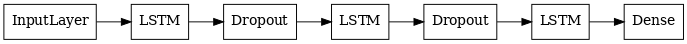

In [58]:
# keras.utils.plot_model(model, to_file='multilayer_perceptron_graph.png')
keras.utils.plot_model(model, to_file='model_3_256.png', show_shapes=False, show_dtype=False, 
                       show_layer_activations=False, rankdir='LR', dpi=70, show_layer_names=False)


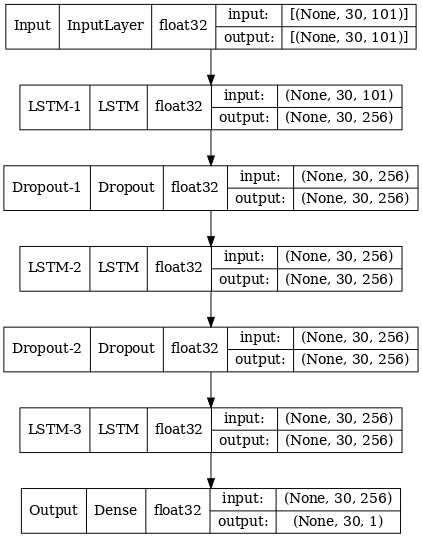

In [57]:
keras.utils.plot_model(model, to_file='model_3_256_detailed.png', show_shapes=True, show_dtype=True, 
                       show_layer_activations=False, rankdir='TB', dpi=70)

In [33]:
NAME='densex2'
model.compile(optimizer = 'adam',  loss='mae',  metrics=['mse', 'mae'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('./data/model/covid_lstm_densex2.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='mae', patience=50, restore_best_weights=True)
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs/{}".format(NAME))
history = model.fit(train_ds, epochs=1024, 
                    validation_data=val_ds, 
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard]
                   )

Epoch 1/1024
1258/1258 [==============================] - 166s 130ms/step - loss: 286.3877 - mse: 487170.2500 - mae: 286.3899 - val_loss: 74.3627 - val_mse: 57117.0859 - val_mae: 74.3627
Epoch 2/1024
1258/1258 [==============================] - 168s 133ms/step - loss: 70.3007 - mse: 55672.8555 - mae: 70.3012 - val_loss: 76.6159 - val_mse: 66050.9375 - val_mae: 76.6159
Epoch 3/1024
1258/1258 [==============================] - 169s 134ms/step - loss: 55.9375 - mse: 49312.1602 - mae: 55.9379 - val_loss: 44.8772 - val_mse: 42978.7578 - val_mae: 44.8772
Epoch 4/1024
1258/1258 [==============================] - 169s 134ms/step - loss: 50.7956 - mse: 47694.0664 - mae: 50.7960 - val_loss: 51.5948 - val_mse: 45373.2539 - val_mae: 51.5948
Epoch 5/1024
1258/1258 [==============================] - 169s 134ms/step - loss: 49.3243 - mse: 47096.4023 - mae: 49.3247 - val_loss: 38.8320 - val_mse: 40160.5117 - val_mae: 38.8319
Epoch 6/1024
1258/1258 [==============================] - 169s 134ms/step - l

In [34]:
# Complex model multi dense

input = keras.layers.Input(shape=(30,101), name='Input')
lstm1 = keras.layers.LSTM(256, return_sequences=True, activation='relu', name='LSTM-1')(input)
dropout1 = keras.layers.Dropout(0.20, name='Dropout-1')(lstm1)
lstm2 = keras.layers.LSTM(256, return_sequences=True, activation='relu', name='LSTM-2')(dropout1)
dropout2 = keras.layers.Dropout(0.20, name='Dropout-2')(lstm2)
lstm3 = keras.layers.LSTM(256, return_sequences=True, activation='relu', name='LSTM-3')(dropout2)
dense = keras.layers.Dense(128, name='Dense', activation='relu')(lstm3)
output = keras.layers.Dense(1, name='Output')(dense)
model = keras.models.Model(inputs=input, outputs=output, name='Covid-Prediction-30-1-Densex2')


NAME='densex2b'
model.compile(optimizer = 'adam',  loss='mae',  metrics=['mse', 'mae'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('./data/model/covid_lstm_densex2b.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='mae', patience=20, restore_best_weights=True)
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs/{}".format(NAME))
history = model.fit(train_ds, epochs=1024, 
                    validation_data=val_ds, 
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard]
                   )

Epoch 1/1024
1258/1258 [==============================] - 202s 159ms/step - loss: 702.1060 - mse: 3367508.0000 - mae: 702.1113 - val_loss: 2734.8110 - val_mse: 58324080.0000 - val_mae: 2734.8113
Epoch 2/1024
1258/1258 [==============================] - 206s 163ms/step - loss: 399.4943 - mse: 617801.5625 - mae: 399.4971 - val_loss: 326.4767 - val_mse: 231288.1562 - val_mae: 326.4768
Epoch 3/1024
1258/1258 [==============================] - 205s 163ms/step - loss: 1041.3079 - mse: 31620510.0000 - mae: 1041.3159 - val_loss: 420.3927 - val_mse: 335565.2500 - val_mae: 420.3929
Epoch 4/1024
1258/1258 [==============================] - 205s 163ms/step - loss: 392.8354 - mse: 979044.5625 - mae: 392.8384 - val_loss: 595.6715 - val_mse: 611720.5000 - val_mae: 595.6714
Epoch 5/1024
1258/1258 [==============================] - 206s 163ms/step - loss: 236.0323 - mse: 169316.1406 - mae: 236.0337 - val_loss: 574.1381 - val_mse: 545858.1875 - val_mae: 574.1381
Epoch 6/1024
1258/1258 [=================

KeyboardInterrupt: 

In [36]:
# Complex model multi dense

input = keras.layers.Input(shape=(30,101), name='Input')
lstm1 = keras.layers.LSTM(256, return_sequences=True, activity_regularizer=tf.keras.regularizers.L2(0.01), name='LSTM-1')(input)
dropout1 = keras.layers.Dropout(0.20, name='Dropout-1')(lstm1)
lstm2 = keras.layers.LSTM(256, return_sequences=True, activity_regularizer=tf.keras.regularizers.L2(0.01), name='LSTM-2')(dropout1)
dropout2 = keras.layers.Dropout(0.20, name='Dropout-2')(lstm2)
lstm3 = keras.layers.LSTM(256, return_sequences=True, activity_regularizer=tf.keras.regularizers.L2(0.01), name='LSTM-3')(dropout2)
dense = keras.layers.Dense(128, name='Dense', activation='relu')(lstm3)
output = keras.layers.Dense(1, name='Output')(dense)
model = keras.models.Model(inputs=input, outputs=output, name='Covid-Prediction-30-1-Densex2')


NAME='densex2c'
model.compile(optimizer = 'adam',  loss='mae',  metrics=['mse', 'mae'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('./data/model/covid_lstm_densex2c.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='mae', patience=20, restore_best_weights=True)
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs/{}".format(NAME))
history = model.fit(train_ds, epochs=1024, 
                    validation_data=val_ds, 
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard]
                   )

Epoch 1/1024
1258/1258 [==============================] - 158s 123ms/step - loss: 458.6237 - mse: 703029.5625 - mae: 417.5659 - val_loss: 211.1664 - val_mse: 111350.6250 - val_mae: 172.6450
Epoch 2/1024
1258/1258 [==============================] - 159s 126ms/step - loss: 137.3796 - mse: 77218.4453 - mae: 105.6222 - val_loss: 96.7032 - val_mse: 49779.1992 - val_mae: 67.5796
Epoch 3/1024
1258/1258 [==============================] - 160s 127ms/step - loss: 90.0491 - mse: 46306.7344 - mae: 61.9814 - val_loss: 89.5690 - val_mse: 45805.0508 - val_mae: 63.5340
Epoch 4/1024
1258/1258 [==============================] - 160s 127ms/step - loss: 77.2846 - mse: 41509.6484 - mae: 52.0244 - val_loss: 73.4656 - val_mse: 43733.3164 - val_mae: 49.8165
Epoch 5/1024
1258/1258 [==============================] - 160s 127ms/step - loss: 67.1152 - mse: 39423.5898 - mae: 44.1189 - val_loss: 61.5279 - val_mse: 34259.3789 - val_mae: 39.3101
Epoch 6/1024
1258/1258 [==============================] - 160s 127ms/ste

In [42]:
# Complex model one dense, batch normalization

train_ds, val_ds, test_ds = dsci.get_train_test_eval_ds()

input = keras.layers.Input(shape=(30,101), name='Input')
lstm1 = keras.layers.LSTM(256, return_sequences=True, name='LSTM-1')(input)
dropout1 = keras.layers.Dropout(0.20, name='Dropout-1')(lstm1)
batchnorm1 = keras.layers.BatchNormalization(name='Batch-Normalization-1')(dropout1)
lstm2 = keras.layers.LSTM(256, return_sequences=True,  name='LSTM-2')(batchnorm1)
dropout2 = keras.layers.Dropout(0.20, name='Dropout-2')(lstm2)
batchnorm2 = keras.layers.BatchNormalization(name='Batch-Normalization-2')(dropout2)
lstm3 = keras.layers.LSTM(256, return_sequences=True,  name='LSTM-3')(batchnorm2)
dropout3 = keras.layers.Dropout(0.20, name='Dropout-3')(lstm3)
batchnorm3 = keras.layers.BatchNormalization(name='Batch-Normalization-3')(dropout3)
output = keras.layers.Dense(1, name='Output')(batchnorm3)
model = keras.models.Model(inputs=input, outputs=output, name='Covid-Prediction-30-1-BatchNorm')

model.summary()

NAME='batchnorm'
model.compile(optimizer = 'adam',  loss='mae',  metrics=['mse', 'mae'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('./data/model/covid_lstm_batchnorm.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='mae', patience=20, restore_best_weights=True)
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs/{}".format(NAME))
history = model.fit(train_ds, epochs=1024, 
                    validation_data=val_ds, 
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard]
                   )


Model: "Covid-Prediction-30-1-BatchNorm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 30, 101)]         0         
                                                                 
 LSTM-1 (LSTM)               (None, 30, 256)           366592    
                                                                 
 Dropout-1 (Dropout)         (None, 30, 256)           0         
                                                                 
 Batch-Normalization-1 (Batc  (None, 30, 256)          1024      
 hNormalization)                                                 
                                                                 
 LSTM-2 (LSTM)               (None, 30, 256)           525312    
                                                                 
 Dropout-2 (Dropout)         (None, 30, 256)           0         
                                   

KeyboardInterrupt: 

In [ ]:
# I added this to the data preprocessing, so not required

class TimeEncoding(keras.layers.Layer):
    """ Layer to encode cyclical and continuous time.  
    Input should an n x 1 array or vector of integers.  
    Integers represent number of time units (i.e., days) from the starting point"""

    def __init__(self, cyclical_interval=365, continuous_interval=3650 , **kwargs):
        self.cyclical_interval = cyclical_interval
        self.continuous_interval = continuous_interval
        super(TimeEncoding, self).__init__(**kwargs)

    def call(self, x):
        
        cyclical_sin = np.sin((x * 2 * np.pi)/self.cyclical_interval)
        cyclical_cos = np.cos((x * 2 * np.pi)/self.cyclical_interval)
        continuous_sin = np.sin((x * 2 * np.pi)/self.continuous_interval)
        continuous_cos = np.cos((x * 2 * np.pi)/self.continuous_interval)
        
        return keras.layers.concatenate([cyclical_sin, cyclical_cos, continuous_sin, continuous_cos], axis=1)
        

In [ ]:
time_encoding = TimeEncoding()
x = np.arange(30)/1.0
x = x[:, tf.newaxis]
time_encoding(x)

input = keras.layers.Input(shape=(30,92))
lstm1 = keras.layers.LSTM(512, return_sequences=True)(input)
dropout1 = keras.layers.Dropout(0.20)(lstm1)
lstm2 = keras.layers.LSTM(512, return_sequences=True)(dropout1)
dropout2 = keras.layers.Dropout(0.20)(lstm2)
lstm3 = keras.layers.LSTM(512, return_sequences=True)(dropout2)
dropout3 = keras.layers.Dropout(0.20)(lstm3)
lstm4 = keras.layers.LSTM(512, return_sequences=True)(dropout3)
dropout4 = keras.layers.Dropout(0.20)(lstm4)
lstm5 = keras.layers.LSTM(512)(dropout4)
output = keras.layers.Dense(1)(lstm5)
model = keras.models.Model(inputs=input, outputs=output)


Output with 5 LSTM @512, one dense layer

Epoch 1/32
1256/1256 [==============================] - 854s 677ms/step - loss: 1525.3854 - mse: 3823870.7500 - mae: 1525.3854 - val_loss: 1395.9611 - val_mse: 3222036.5000 - val_mae: 1395.9611
Epoch 2/32
1256/1256 [==============================] - 860s 685ms/step - loss: 1306.3831 - mse: 2720509.2500 - mae: 1306.3831 - val_loss: 1268.0597 - val_mse: 2458543.2500 - val_mae: 1268.0597
Epoch 3/32
1256/1256 [==============================] - 861s 686ms/step - loss: 1224.3491 - mse: 2193218.7500 - mae: 1224.3491 - val_loss: 1221.3195 - val_mse: 2095028.1250 - val_mae: 1221.3195
Epoch 4/32
1256/1256 [==============================] - 861s 685ms/step - loss: 1190.3538 - mse: 1940674.8750 - mae: 1190.3538 - val_loss: 1205.6909 - val_mse: 1935832.7500 - val_mae: 1205.6909
Epoch 5/32
1256/1256 [==============================] - 857s 682ms/step - loss: 1179.1588 - mse: 1829032.5000 - mae: 1179.1588 - val_loss: 1197.5588 - val_mse: 1859381.2500 - val_mae: 1197.5588
Epoch 6/32
1256/1256 [==============================] - 857s 682ms/step - loss: 1173.8285 - mse: 1778276.3750 - mae: 1173.8285 - val_loss: 1195.9708 - val_mse: 1827763.8750 - val_mae: 1195.9708
Epoch 7/32
1256/1256 [==============================] - 858s 683ms/step - loss: 1170.9568 - mse: 1751288.7500 - mae: 1170.9568 - val_loss: 1193.4899 - val_mse: 1804784.8750 - val_mae: 1193.4899
Epoch 8/32
1256/1256 [==============================] - 859s 684ms/step - loss: 1168.4807 - mse: 1736100.6250 - mae: 1168.4807 - val_loss: 1190.9672 - val_mse: 1791784.7500 - val_mae: 1190.9672
Epoch 9/32
1256/1256 [==============================] - 856s 682ms/step - loss: 1166.9685 - mse: 1730238.2500 - mae: 1166.9685 - val_loss: 1191.2921 - val_mse: 1792275.2500 - val_mae: 1191.2921
Epoch 10/32
1256/1256 [==============================] - 855s 681ms/step - loss: 1166.2148 - mse: 1729396.2500 - mae: 1166.2148 - val_loss: 1189.8693 - val_mse: 1789450.0000 - val_mae: 1189.8693
Epoch 11/32
1256/1256 [==============================] - 856s 681ms/step - loss: 1165.9210 - mse: 1729189.6250 - mae: 1165.9210 - val_loss: 1190.8143 - val_mse: 1792432.6250 - val_mae: 1190.8143
Epoch 12/32
1256/1256 [==============================] - 856s 682ms/step - loss: 1165.8933 - mse: 1730290.7500 - mae: 1165.8933 - val_loss: 1190.2284 - val_mse: 1791079.6250 - val_mae: 1190.2284
Epoch 13/32
1256/1256 [==============================] - 857s 682ms/step - loss: 1165.8029 - mse: 1731005.8750 - mae: 1165.8029 - val_loss: 1189.7284 - val_mse: 1790104.0000 - val_mae: 1189.7284
Epoch 14/32
1256/1256 [==============================] - 854s 680ms/step - loss: 1165.6666 - mse: 1729771.0000 - mae: 1165.6666 - val_loss: 1190.9232 - val_mse: 1793442.3750 - val_mae: 1190.9232
Epoch 15/32
1256/1256 [==============================] - 853s 680ms/step - loss: 1166.0372 - mse: 1731329.2500 - mae: 1166.0372 - val_loss: 1190.1742 - val_mse: 1791922.6250 - val_mae: 1190.1742
Epoch 16/32
 532/1256 [===========>..................] - ETA: 7:34 - loss: 1170.4701 - mse: 1743321.3750 - mae: 1170.4701